In [340]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from util.StringObjectParser import StringObjectParser

In [341]:
sns.set_theme(style="whitegrid")

# Load Data

## Subsetting Performance

In [342]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

xlsx_files = [file for file in os.listdir(current_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(current_directory, xf))
    df["subsetting_method"] = xf.split("-")[1]
    df["benchmark"] = xf.split("-")[2]
    df["comments"] = xf.split("-")[4].replace(".xlsx", "")
    dataframes.append(df)
performance_df = pd.concat(dataframes, ignore_index=True)


The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/subsetting_results


## Subsetting Diagnosis

Subsetting diagnosis contains the results of the subseeting_diagnosis.py script. 

Columns:
- **database** (str): benchmark database associated with question
- **question_number** (int): benchmark database NL-SQL question number
- **gold_query_tables** (set): minimum tables required for a correct query
- **missing_tables** (set): gold_query_tables - tables in predicted subset
- **hidden_tables** (set): missing tables that are not semantically similar to any n-grams in the natural language question
- **ambiguous_extra_tables** (dict): a dict of natural language words that are semantically similar to tables in the schema that are not in the gold query. The dict key is the natural language word, and the value is a set of table names.
- **gold_query_columns** (set): minimum columns required for a correct query, formatted as table.column
- **missing_columns** (set): gold_query_columns - columns in predicted subset
- **value_reference_problem_columns** (dict): Missing columns where a word in the natural language question is semantically similar to a value in the required column, but there is no NL word match to the required column.
-- **ambiguous_extra_columns** (dict):  a dict of natural language words that are semantically similar to columns in the schema that are not in the gold query. The dict key is the natural language word, and the value is a set of column names formatted as table.column.

In [343]:
current_directory = f"{os.getcwd()}/diagnosis"
xlsx_files = [file for file in os.listdir(current_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(current_directory, xf))
    df = df.rename(columns={
        "hidden_relations": "hidden_tables",
        "value_reference_problem_attributes": "value_reference_problem_columns",
        "gold_query_attributes": "gold_query_columns",
        "missing_attributes": "missing_columns"
        })
    df = df.drop(columns=["value_reference_problem_relations"], errors="ignore")
    df["subsetting_method"] = xf.split("-")[2]
    df["benchmark"] = xf.split("-")[3]
    df["comments"] = xf.split("-")[-1].replace(".xlsx", "")
    dataframes.append(df)
diagnosis_df = pd.concat(dataframes, ignore_index=True)

## Preprocessing Times

In [344]:
current_directory = f"{os.getcwd()}/preprocessing_times"
json_files = [file for file in os.listdir(current_directory) if file.endswith('_processing.json')]
df_dict = {"subsetting_method": [], "benchmark": [], "database": [], "processing_time": [], "comment": []}
for filename in json_files:
    fn_split = filename.split("_")
    if "not_for_performance_evaluation" in filename or "abstract" in filename:
        continue
    time_dict = json.loads(open(f"{current_directory}/{filename}", "r").read())
    for k in time_dict:
        if k in ["total", "ga360", "bls", "irs_990"]:
            continue
        df_dict["subsetting_method"].append(fn_split[0])
        df_dict["benchmark"].append(fn_split[1])
        df_dict["database"].append(k)
        df_dict["processing_time"].append(time_dict[k])
        df_dict["comment"].append(fn_split[-2])
processing_time_df = pd.DataFrame(df_dict)
    

## Schema Stats

In [345]:
current_directory = f"{os.getcwd()}/benchmark_schema_stats"
json_files = [file for file in os.listdir(current_directory) if file.endswith('_stats.json')]
df_dict = {"benchmark": [], "database": [], "table_count": [], "column_count": []}
for filename in json_files:
    fn_split = filename.split("_")
    stat_dict = json.loads(open(f"{current_directory}/{filename}", "r").read())
    for k in stat_dict:
        df_dict["benchmark"].append(fn_split[0])
        df_dict["database"].append(k)
        df_dict["table_count"].append(stat_dict[k]["table_count"])
        df_dict["column_count"].append(stat_dict[k]["column_count"])
schema_stat_df = pd.DataFrame(df_dict).query("benchmark!='abstract'")

# Process Data

## Model Filter

In [346]:
comment_model_filter = {
    "CodeS": "lambda1_sic_merged",
    "DINSQL": "gpt41",
    "chess": "gpt4o",
    "crush4sql": "lambda1",
    "dtssql": "lambda1",
    "rslsql": "gpt4o",
    "tasql": "gpt41"
}

## Display Data Maps

In [347]:
performance_df.subsetting_method.unique()

array(['crush4sql', 'rslsql', 'dtssql', 'CodeS', 'tasql', 'chess',
       'DINSQL'], dtype=object)

In [348]:
subsetting_display_names = {
    "crush4sql": "Crush",
    "rslsql": "RSLSQL",
    "tasql": "TASQL",
    "CodeS": "CodeS",
    "dtssql": "DTSSQL",
    "chess": "CHESS",
    "DINSQL": "DINSQL"
}

In [349]:
subsetting_classifications = {
    "crush4sql": "Hyb",
    "rslsql": "LLM",
    "tasql": "LLM",
    "CodeS": "ML",
    "dtssql": "LLM",
    "chess": "Hyb",
    "DINSQL": "LLM"
}

## Process Performance Data

In [350]:
# Simple replacement of "set()" with actual set
performance_df = performance_df.replace("set()", "{None}")

In [351]:
# Annotate (True, False) if all models were able to handle a specific schema (e.g., it fit inside the context window)
# We can recognize databases where some models failed if the inference time is -1
too_big_schemas = list(performance_df.query("inference_time<0").database.unique())
performance_df["all_models_compatible"] = performance_df.database.apply(lambda x: x not in too_big_schemas)

In [352]:
performance_df["Subsetting Method"] = performance_df.subsetting_method.apply(lambda x: subsetting_display_names[x])

In [353]:
performance_df["eval_model"] = performance_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
    )

## Process Processing Time Data

In [354]:
temp_data_df = schema_stat_df.set_index(["benchmark", "database"])
processing_time_df["seconds_per_column"] = processing_time_df.apply(
    lambda row: row.processing_time / temp_data_df.loc[row.benchmark, row.database]["column_count"],
    axis=1
)

In [355]:
processing_time_df["Subsetting Method"] = processing_time_df.subsetting_method.apply(lambda x: subsetting_display_names[x])

In [356]:
processing_time_df["eval_model"] = processing_time_df.apply(
    lambda row: row.comment == comment_model_filter[row.subsetting_method],
    axis=1
)

## Process Diagnosis Data

In [357]:
diagnosis_df["missing_tables_count"] = diagnosis_df.missing_tables.apply(
    lambda x: len(StringObjectParser.string_to_python_object(x, use_eval=True))
    )
diagnosis_df["hidden_tables_count"] = diagnosis_df.hidden_tables.apply(
    lambda x: len(StringObjectParser.string_to_python_object(x, use_eval=True))
)
def count_ambiguous(amb_dict: dict) -> int:
    idents = set()
    for k in amb_dict:
        idents = idents.union(amb_dict[k])
    return len(idents)
diagnosis_df["ambiguous_extra_tables_count"] = diagnosis_df.ambiguous_extra_tables.apply(
    lambda x: count_ambiguous(StringObjectParser.string_to_python_object(x, use_eval=True))
)
diagnosis_df["missing_columns_count"] = diagnosis_df.missing_columns.apply(
    lambda x: len(StringObjectParser.string_to_python_object(x, use_eval=True))
)
diagnosis_df["value_reference_problem_columns_count"] = diagnosis_df.value_reference_problem_columns.apply(
    lambda x: len(StringObjectParser.string_to_python_object(x, use_eval=True).keys())
)
diagnosis_df["ambiguous_extra_columns_count"] = diagnosis_df.ambiguous_extra_columns.apply(
    lambda x: count_ambiguous(StringObjectParser.string_to_python_object(x, use_eval=True))
)
diagnosis_df["Subsetting Method"] = diagnosis_df.subsetting_method.apply(
    lambda x: subsetting_display_names[x]
    )
diagnosis_df["eval_model"] = diagnosis_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
)

/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:51: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")
/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:51: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")
/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:51: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")
/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:51: UserWarning: Using eval can be dangerous

## Process Schema Stat Data

### Schema Size
Size is calculated in terms of the number of columns in the schema. Sizes are determined logarithmically, where size increases along powers of 10 (e.g. <= 10 columns = xs, <= 100 = s, 1000, 100000, etc.)

In [358]:
schema_sizes = {
    100: "s",
    1000: "m",
    2500: "l",
    100000: "xl"
}

def get_size(x: int) -> str:
    for s in schema_sizes.keys():
        if x < s:
            return schema_sizes[s]


schema_size_map = {
    "s": 100,
    "m": 1000,
    "l": 2500,
    "xl": 100000
}

schema_stat_df["size_cat"] = schema_stat_df.column_count.apply(
    lambda x: get_size(x) 
    )
schema_stat_df["size_descr"] = schema_stat_df.size_cat.apply(
    lambda x: f"col<{schema_size_map[x]:,}"
)
schema_stat_df["size_sort"] = schema_stat_df.size_cat.apply(
    lambda x: schema_size_map[x]
)

schema_stat_df["mean_table_size"] = schema_stat_df.apply(
    lambda row: row.column_count / row.table_count,
    axis=1
)

# EDA

## Schema Stats

### Column Count Distribution (Log scale)

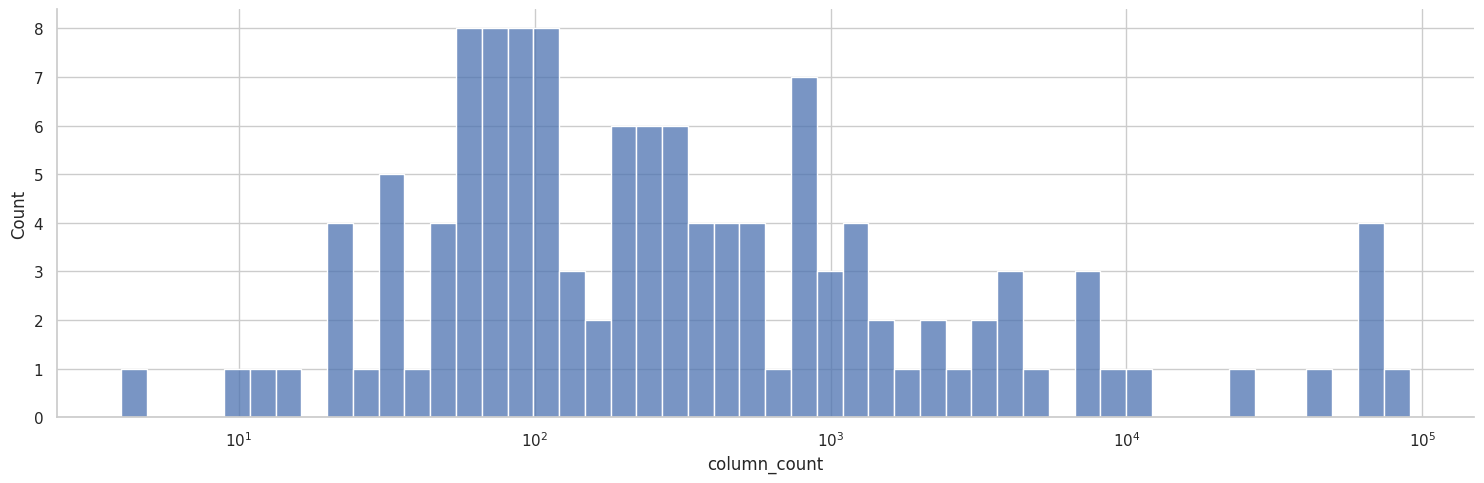

In [359]:
sns.displot(
    data=schema_stat_df,
    x="column_count",
    # hue="type",
    bins=50,
    aspect=3,
    log_scale=[True, False]
)

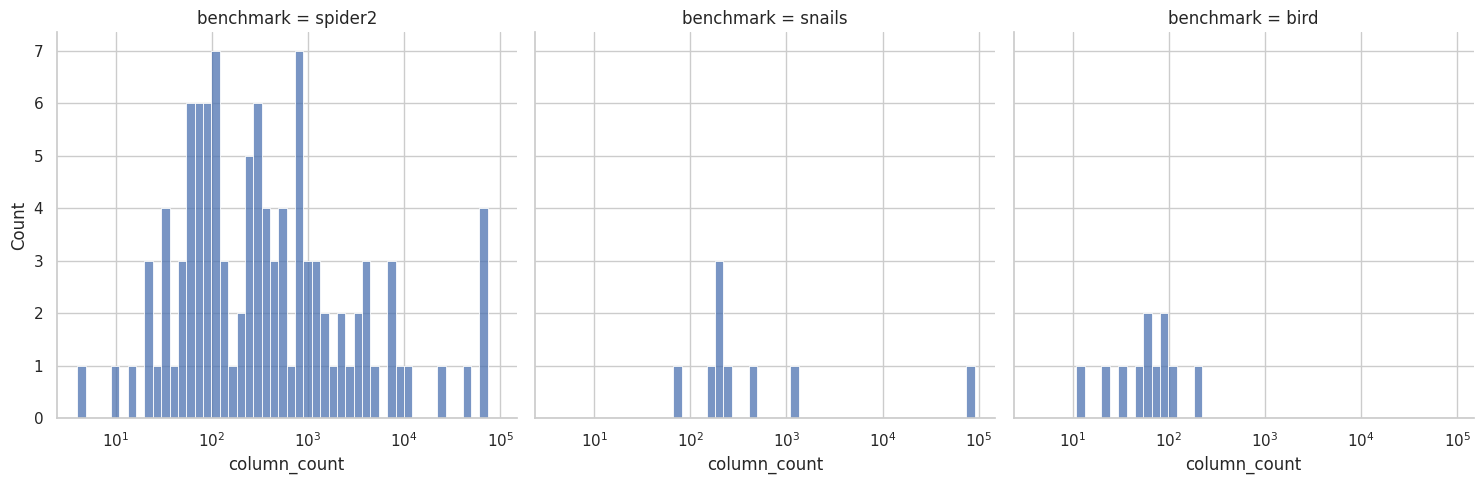

In [360]:
sns.displot(
    data=schema_stat_df,
    x="column_count",
    # hue="type",
    bins=50,
    aspect=1,
    col="benchmark",
    log_scale=[True, False]
)

### Table Count Distribution (Log scale)

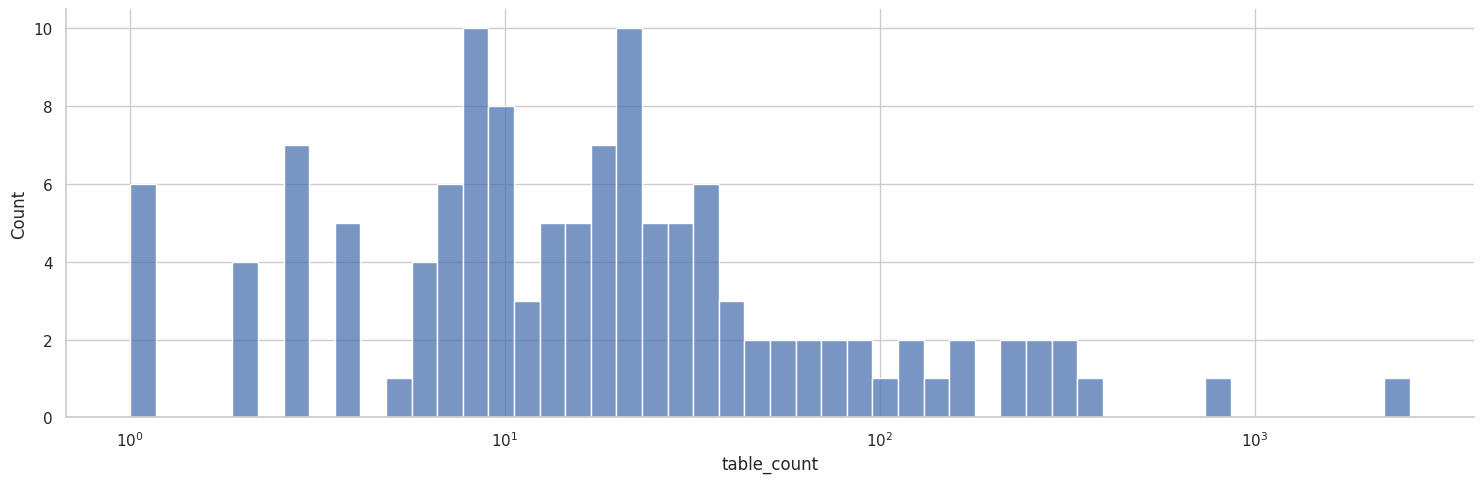

In [361]:
sns.displot(
    data=schema_stat_df,
    x="table_count",
    # hue="type",
    bins=50,
    aspect=3,
    log_scale=[True, False]
)

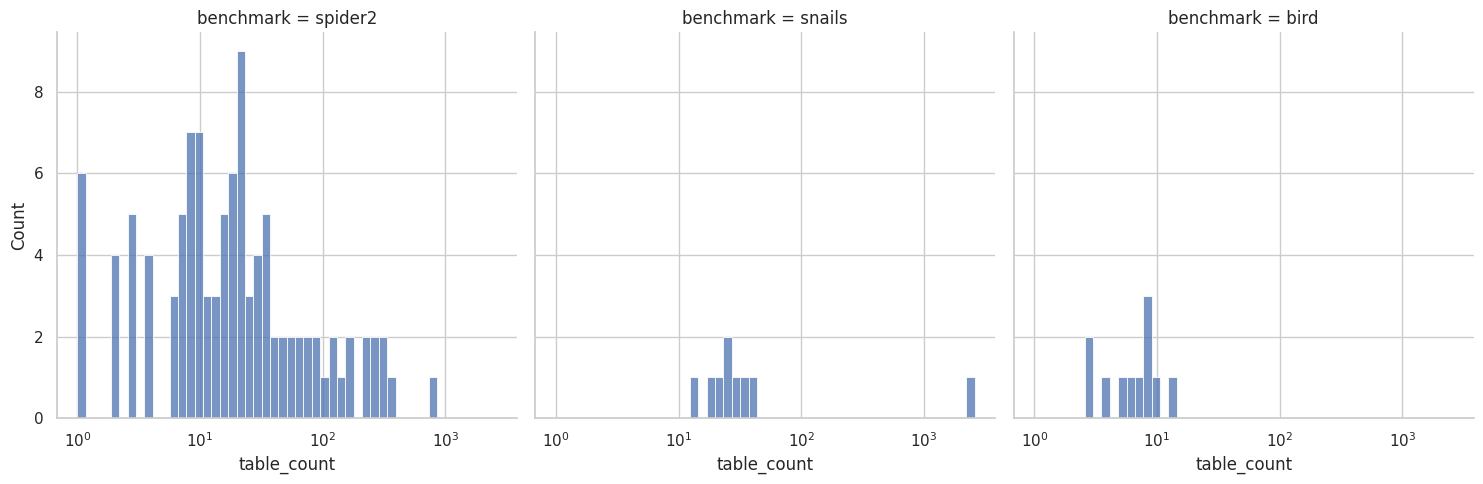

In [362]:
sns.displot(
    data=schema_stat_df,
    x="table_count",
    # hue="type",
    bins=50,
    aspect=1,
    log_scale=[True, False],
    col="benchmark"
)

### Mean Table Size (column count / table count) distribution

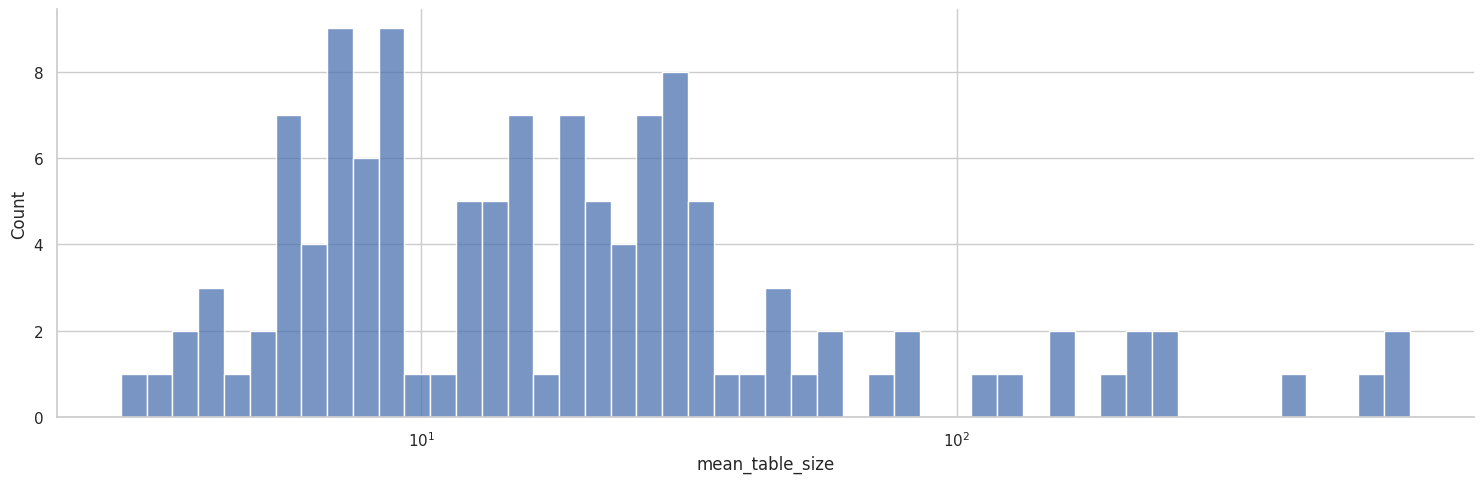

In [363]:
sns.displot(
    data=schema_stat_df,
    x="mean_table_size",
    # hue="type",
    bins=50,
    aspect=3,
    log_scale=[True, False]
)

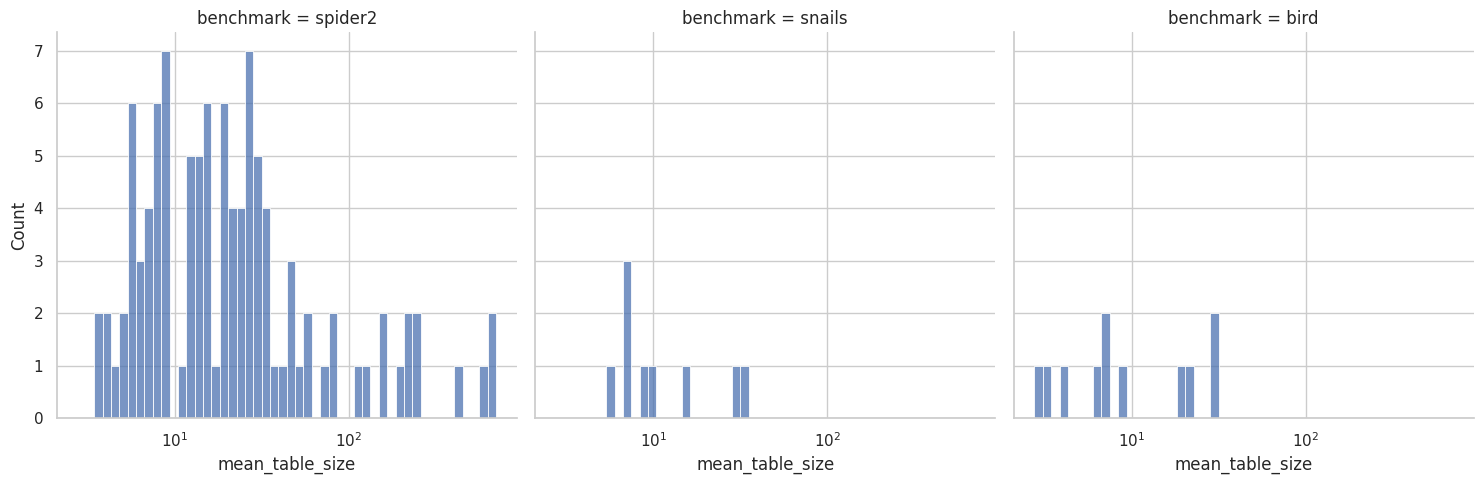

In [364]:
sns.displot(
    data=schema_stat_df,
    x="mean_table_size",
    # hue="type",
    bins=50,
    aspect=1,
    log_scale=[True, False],
    col="benchmark"
)

### Schema Size Counts Table by Benchmark 

In [365]:
temp_data_df = schema_stat_df.copy()
temp_data_df["Size"] = temp_data_df.apply(lambda row: f"{row.size_cat.upper()}", axis=1)
temp_data_df["Columns"] = temp_data_df.apply(lambda row: row.size_descr.replace("col", ""), axis=1)
temp_data_df = temp_data_df.pivot_table(
    index=["Size", "Columns", "size_sort"],
    columns="benchmark",
    values="database",
    aggfunc="count"
).fillna(0)
temp_data_df["Total"] = temp_data_df.apply(lambda row: row.bird + row.snails + row.spider2, axis=1)
temp_data_df = temp_data_df.astype(int).reset_index().sort_values(by="size_sort")
temp_data_df = temp_data_df.drop("size_sort", axis=1)
temp_data_df.to_latex(
    buf=f"{os.getcwd()}/tables/benchmark_schema_size_table.tex",
    index=False,
    header=["Size", "Columns", "Bird", "Snails", "Spider2", "Total"],
    label=f"tab:benchmark-schema-sizes",
    caption="Schema size distribution for each benchmark dataset. "
)

## Performance Distributions

### Recall, precision, and f1

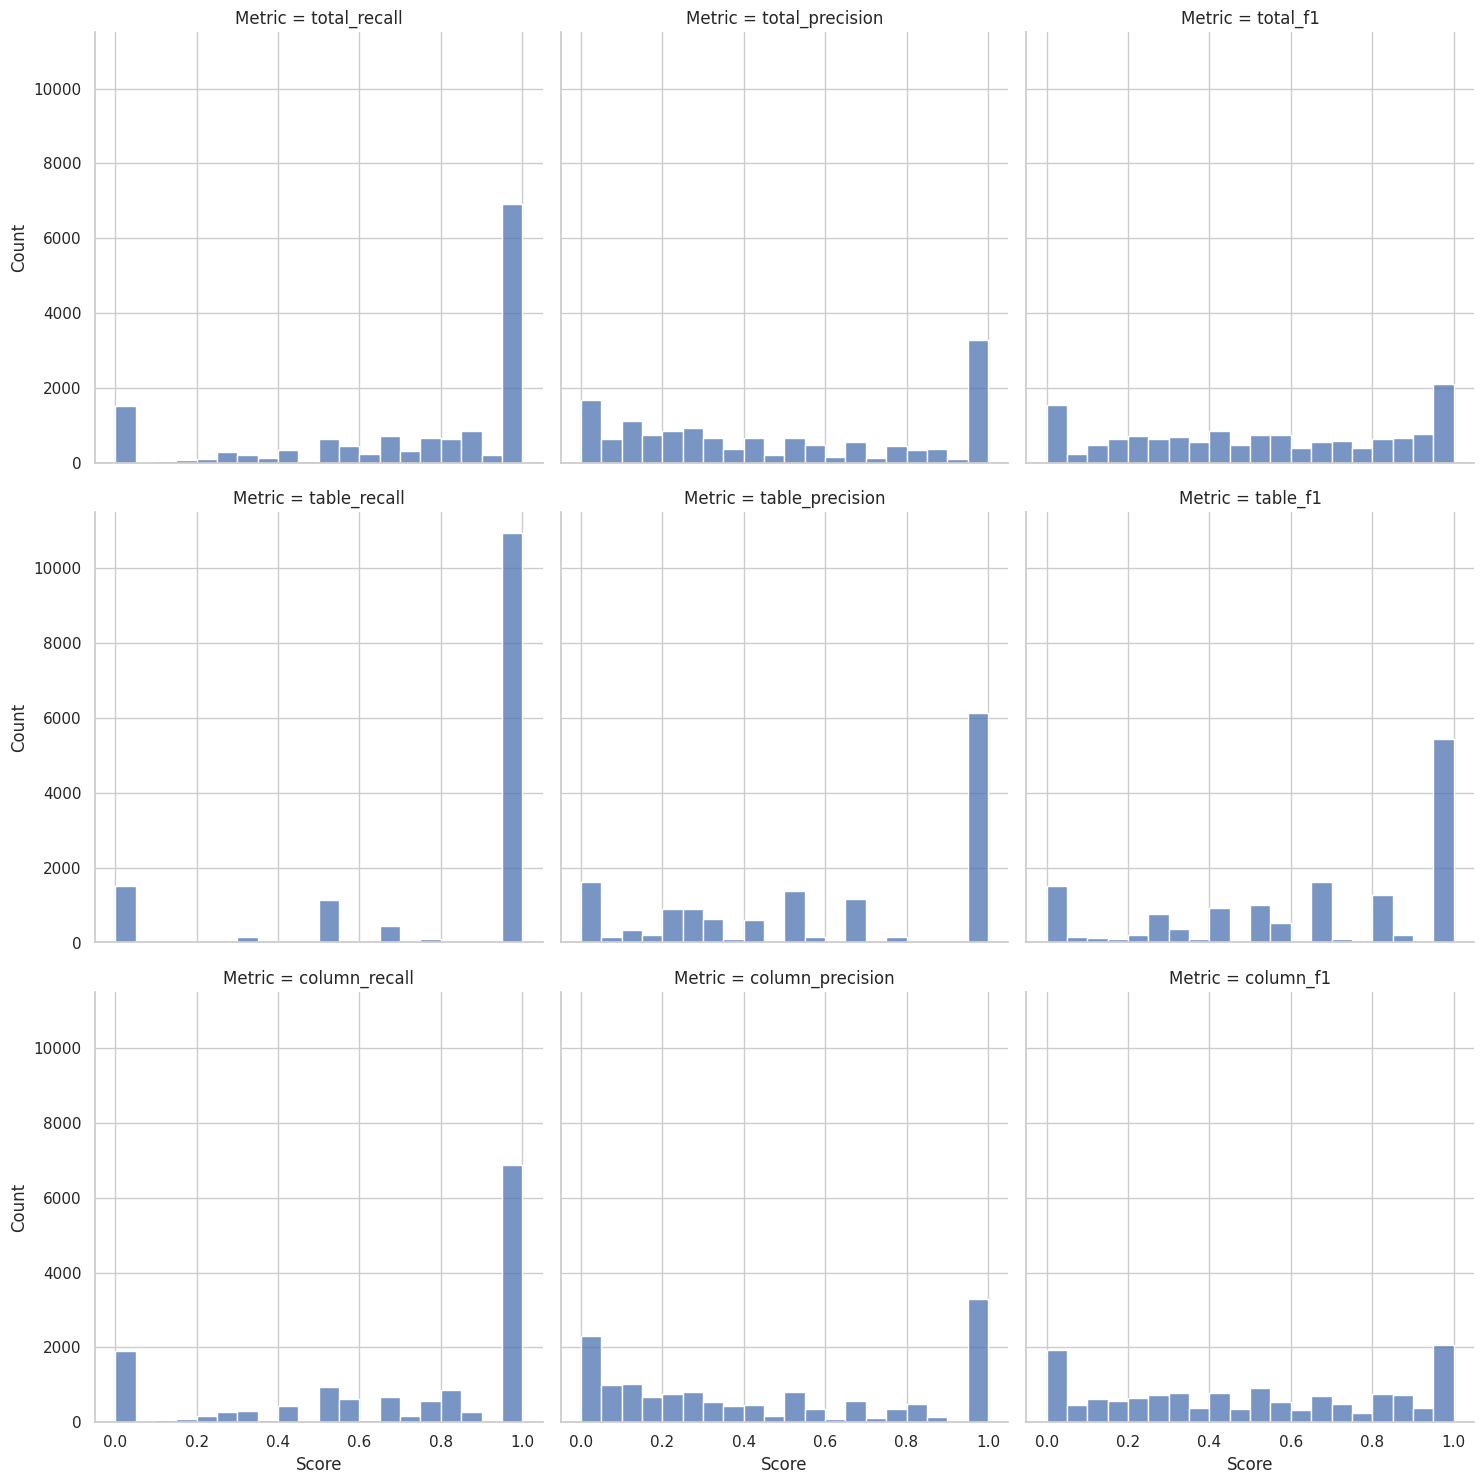

In [366]:
sns.displot(
    data=performance_df.query(
        "prompt_tokens>=0 and eval_model"
    ).melt(
        id_vars=["benchmark", "subsetting_method"],
        value_vars=[
            "total_recall", "total_precision", "total_f1", 
            "table_recall", "table_precision", "table_f1",
            "column_recall", "column_precision", "column_f1"
            ],
        value_name="Score",
        var_name="Metric"
    ),
    x="Score",
    col="Metric",
    col_wrap=3,
    bins=20
)

### Recall, precision, and f1 by benchmark

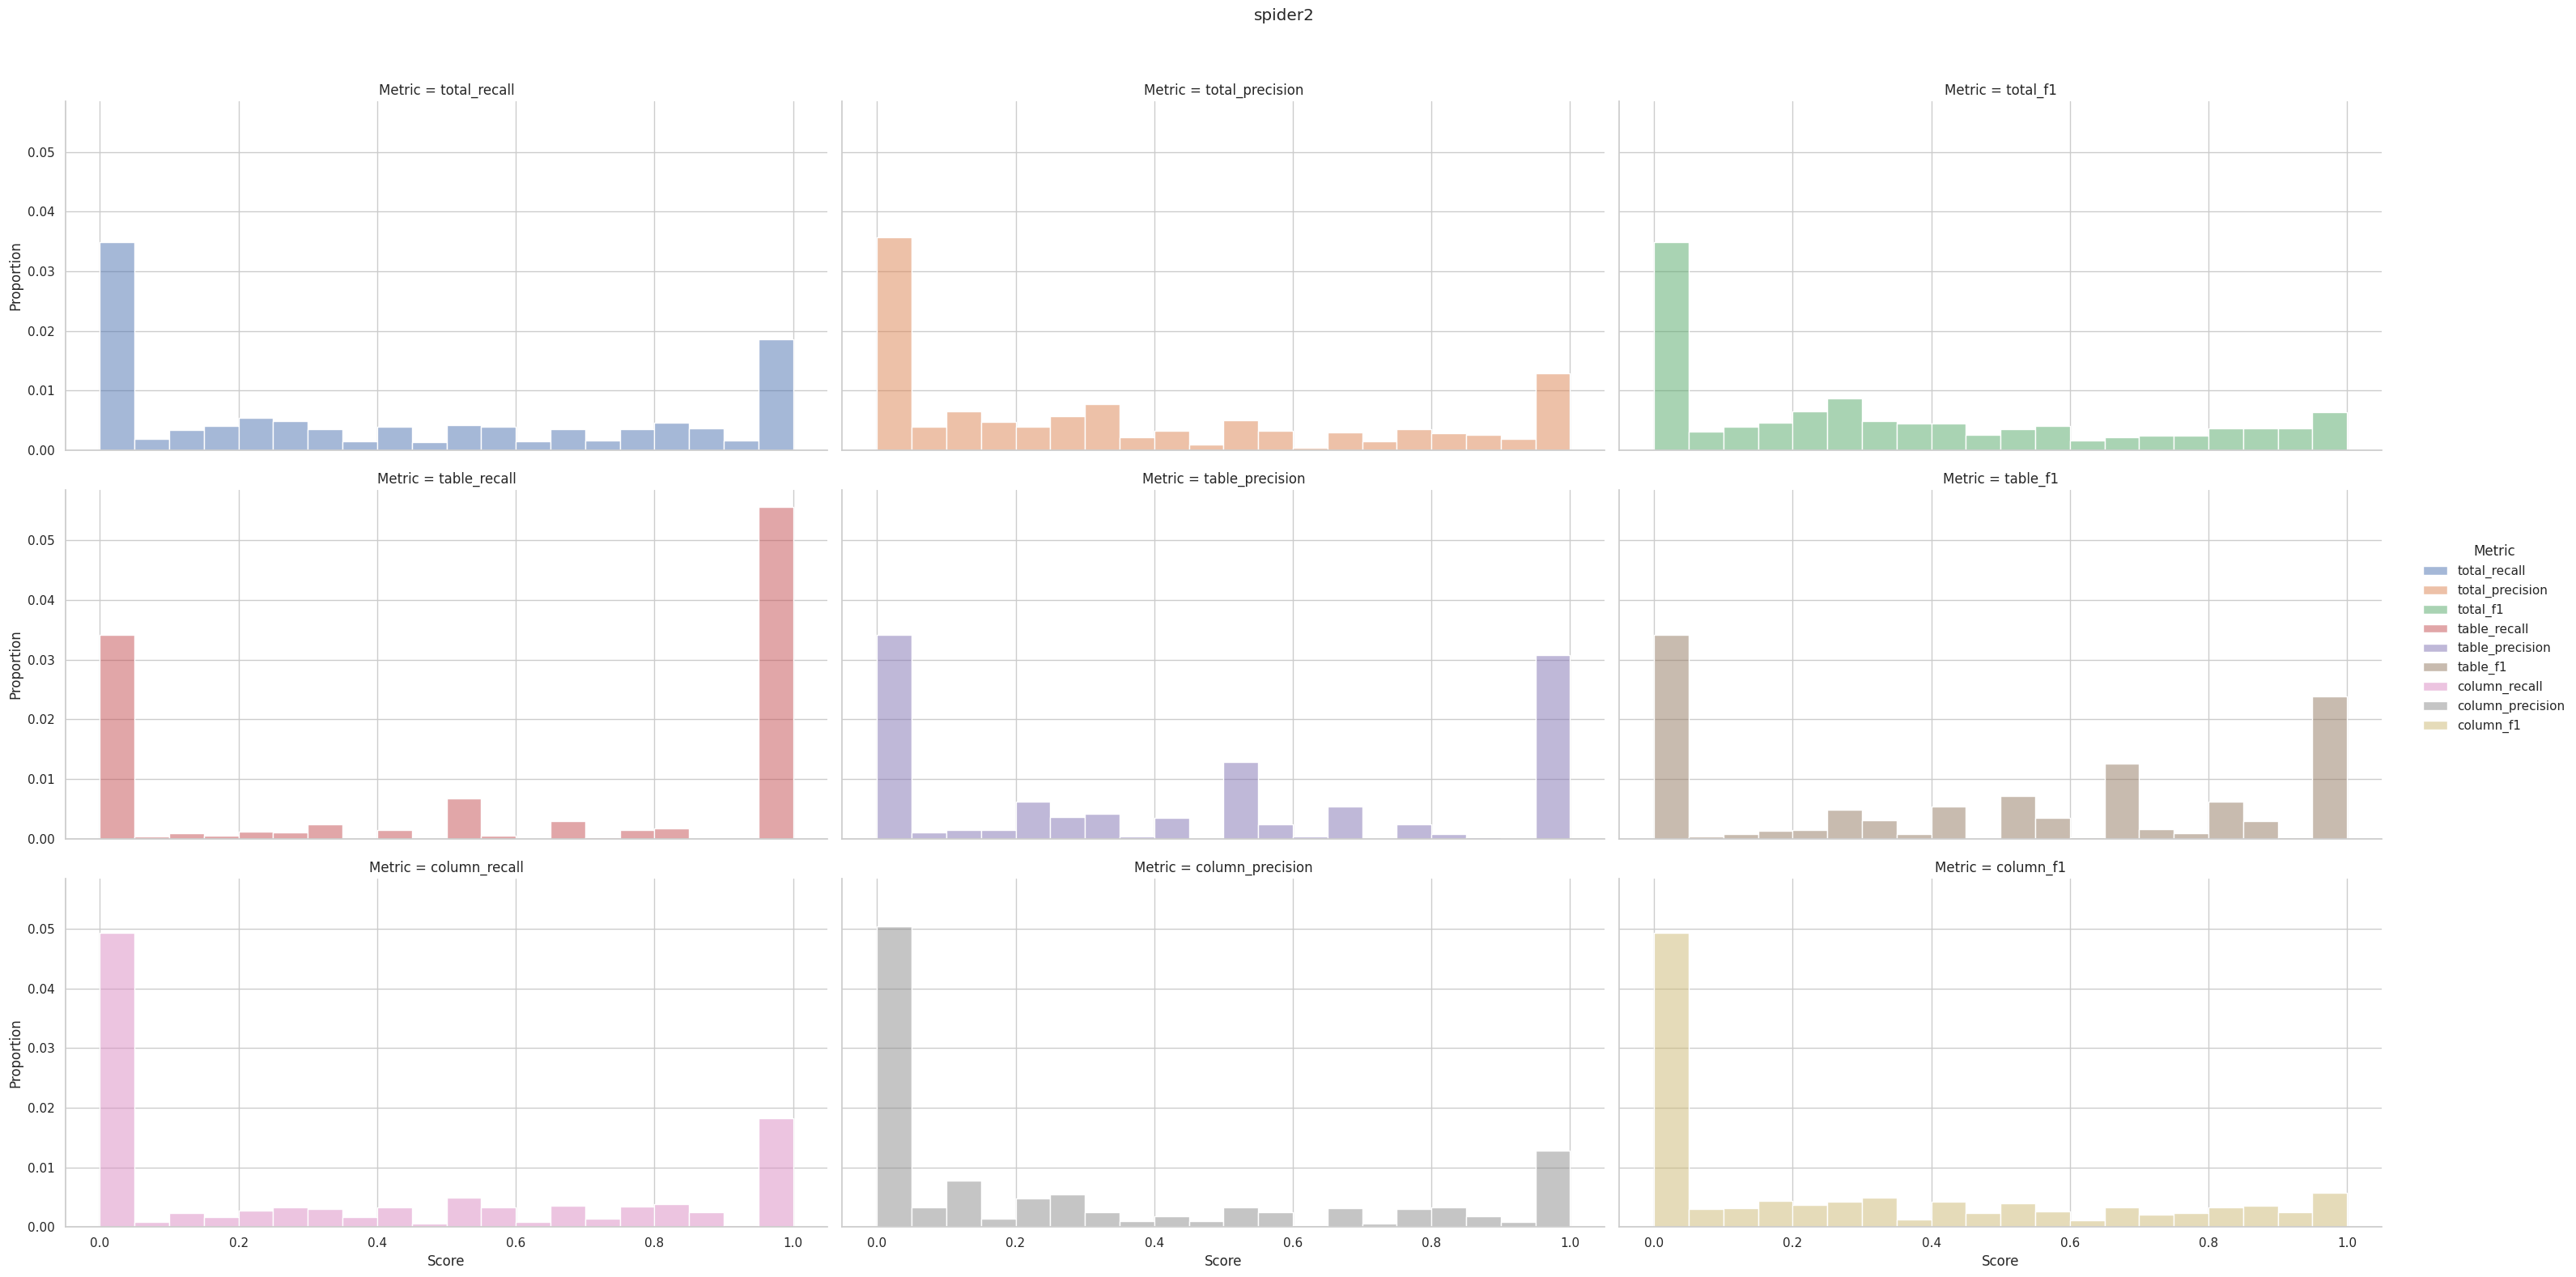

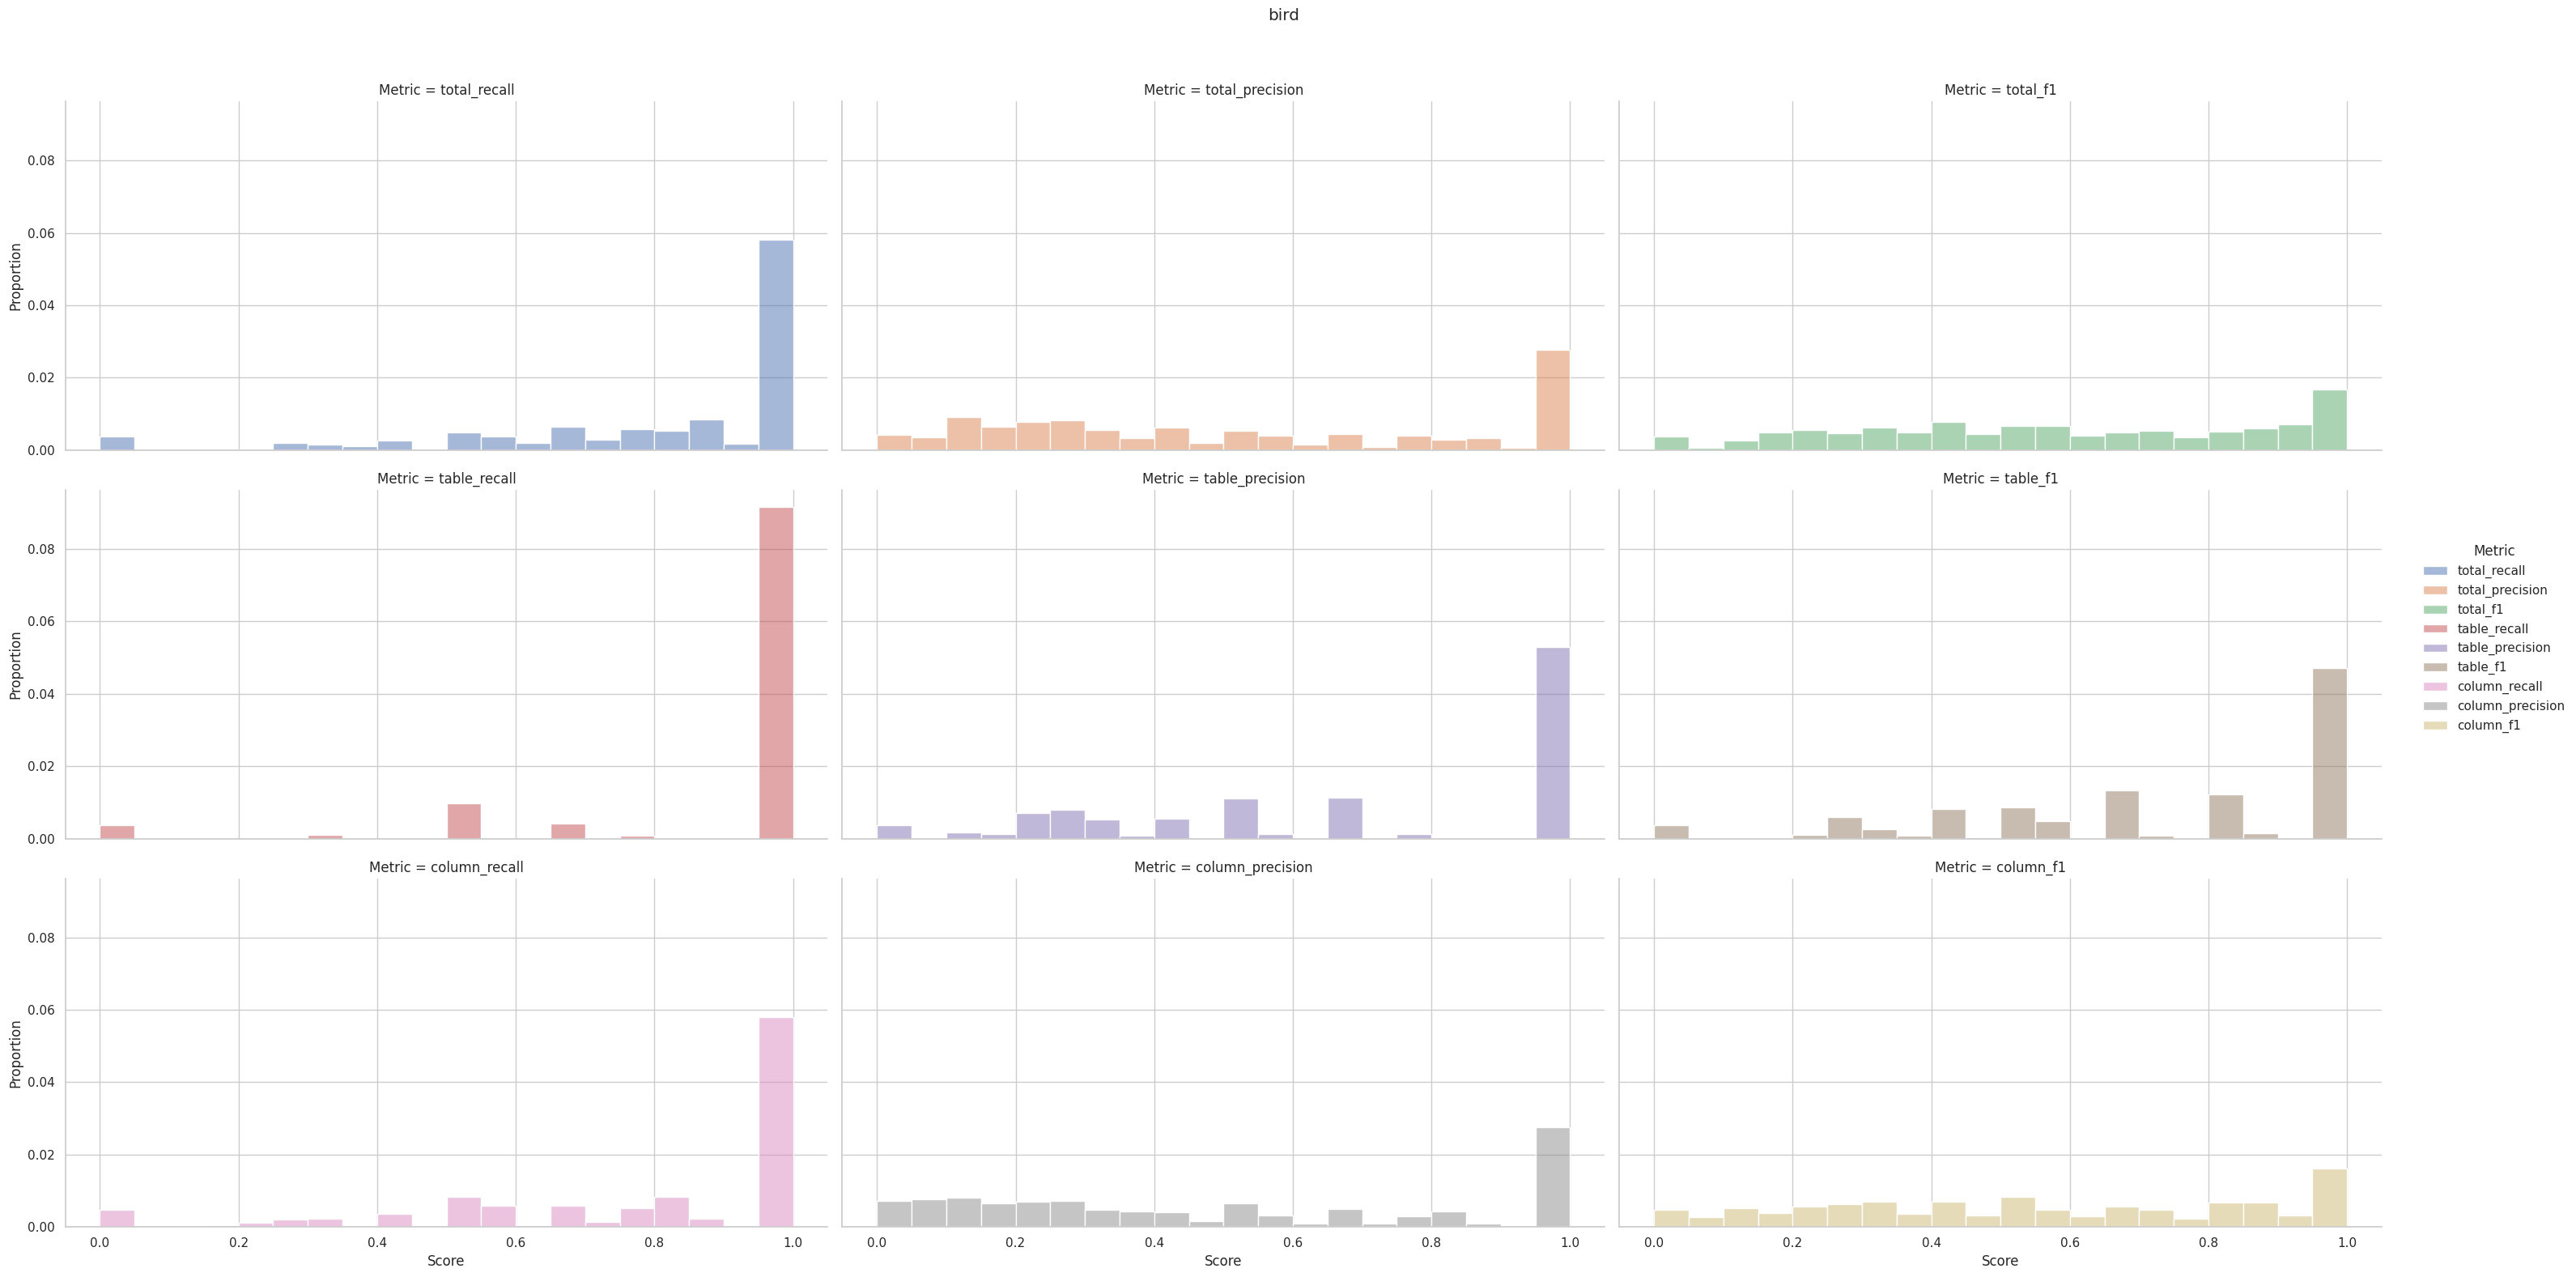

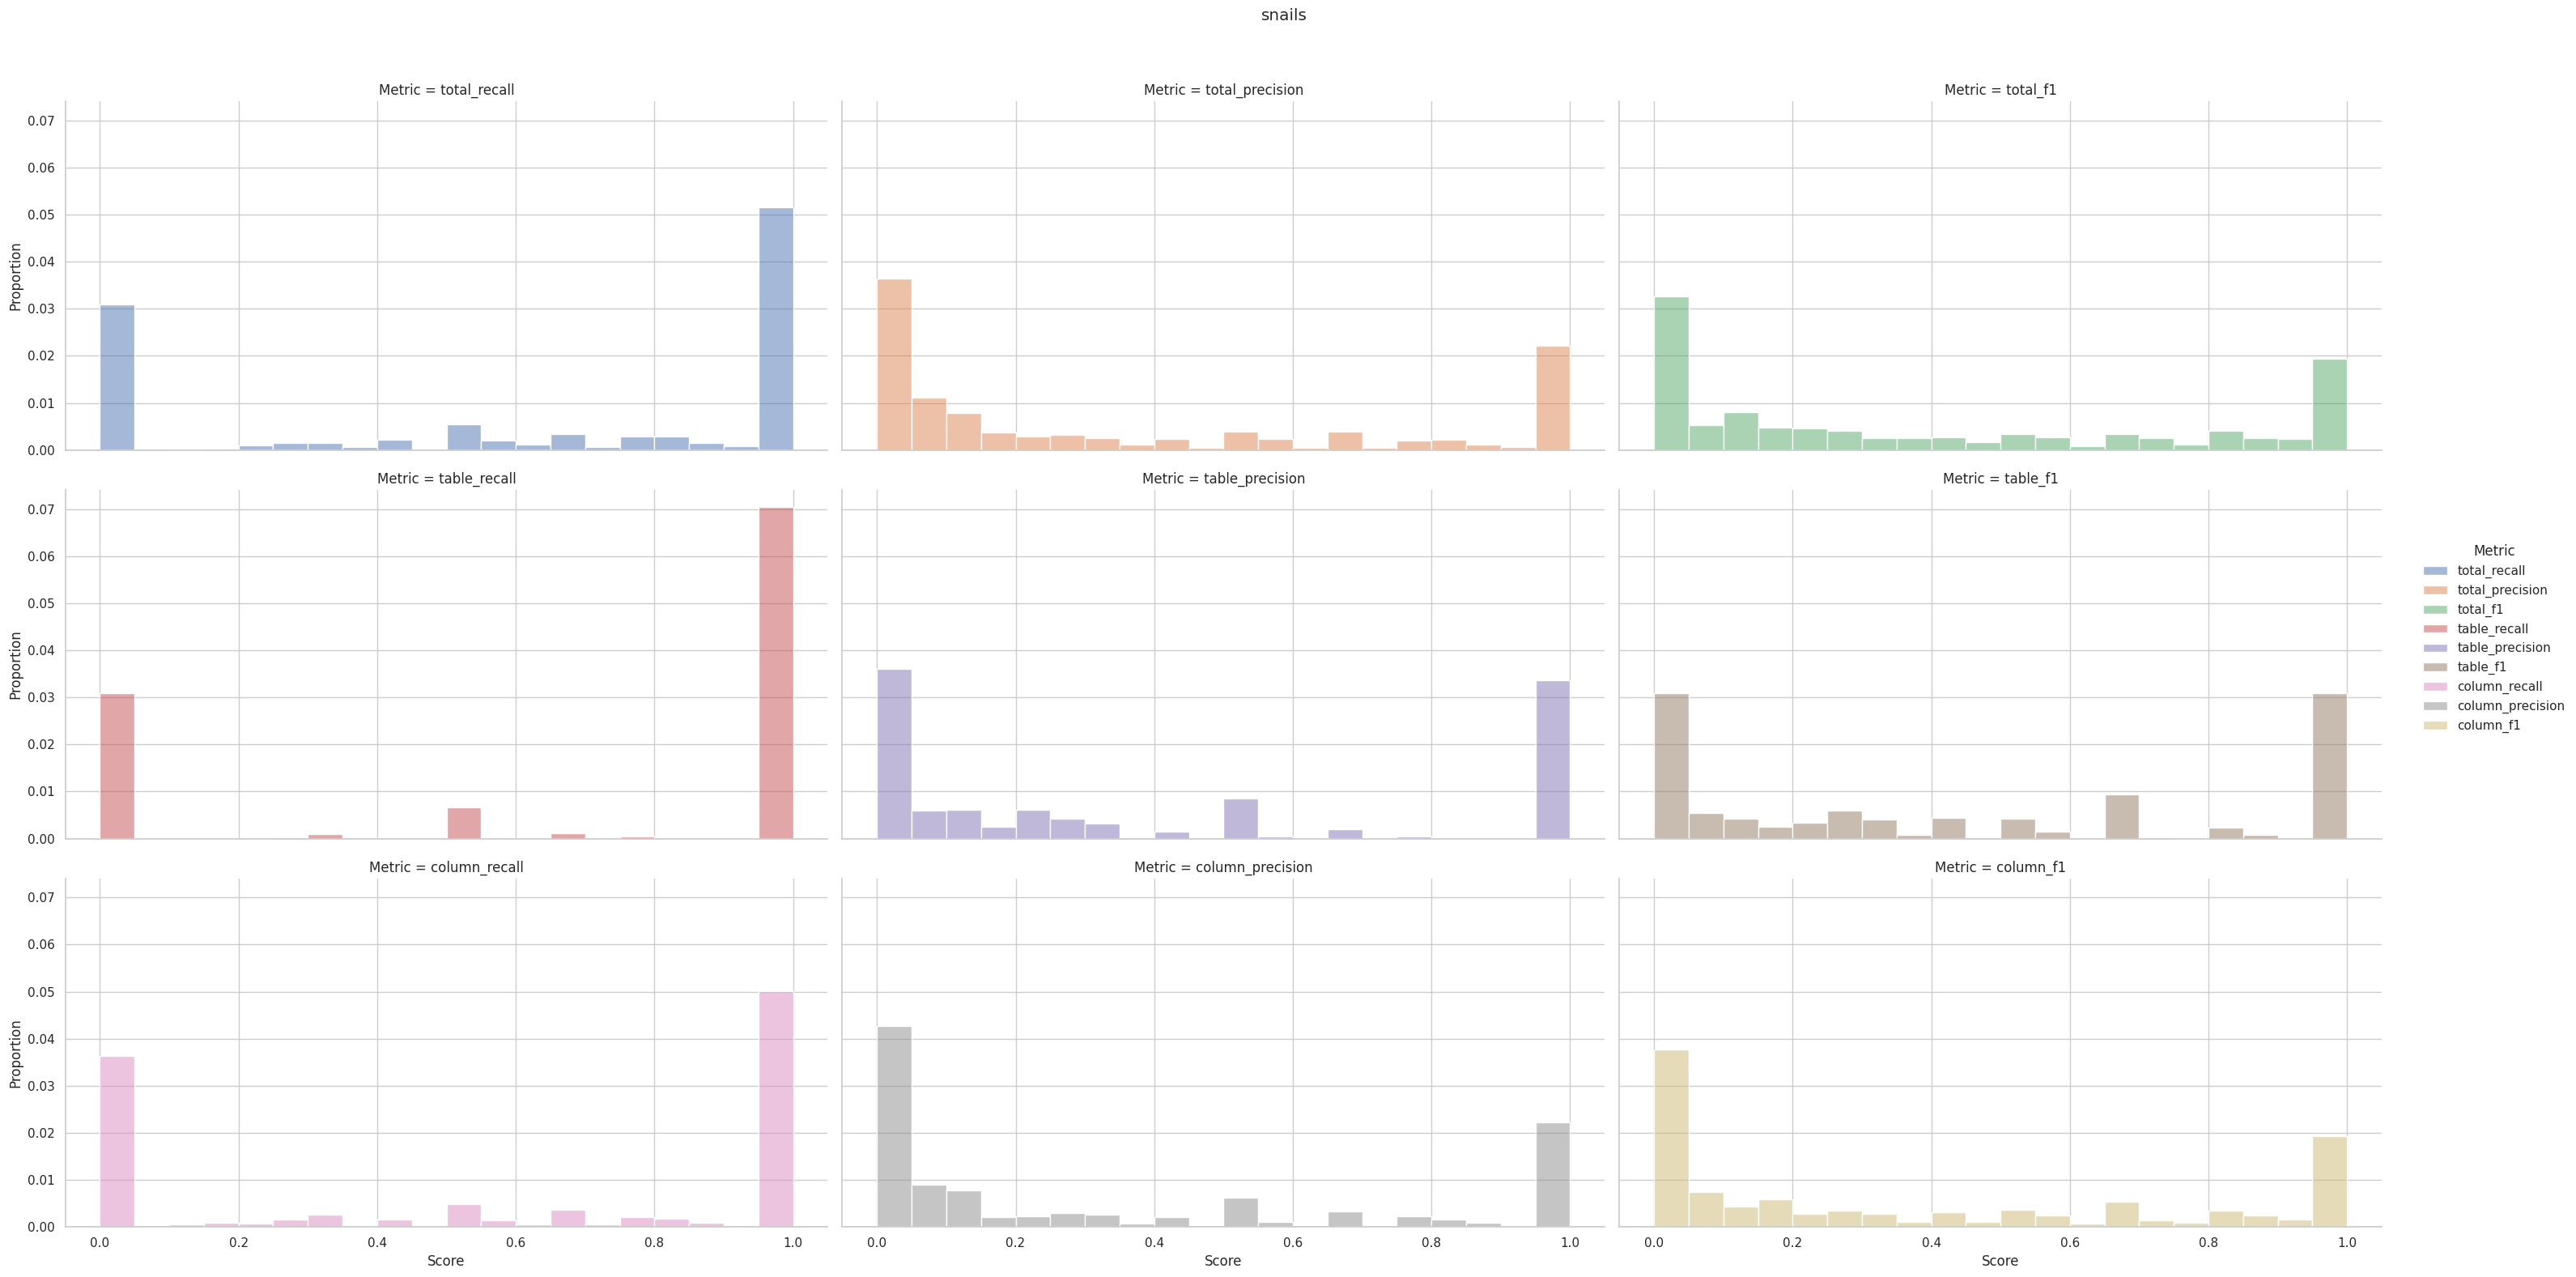

In [367]:
for bm in ["spider2", "bird", "snails"]:
    g = sns.displot(
        data=performance_df.query(f"benchmark=='{bm}' and prompt_tokens>=0 and eval_model").melt(
            id_vars=["benchmark", "subsetting_method"],
            value_vars=[
                "total_recall", "total_precision", "total_f1", 
                "table_recall", "table_precision", "table_f1",
                "column_recall", "column_precision", "column_f1"
                ],
            value_name="Score",
            var_name="Metric"
        ),
        x="Score",
        hue="Metric",
        kind="hist",
        stat="proportion",
        aspect=2,
        col="Metric",
        col_wrap=3,
        bins=20
    )
    g.figure.suptitle(bm, y=1.05)

### Recall, precision, and f1 by method and benchmark

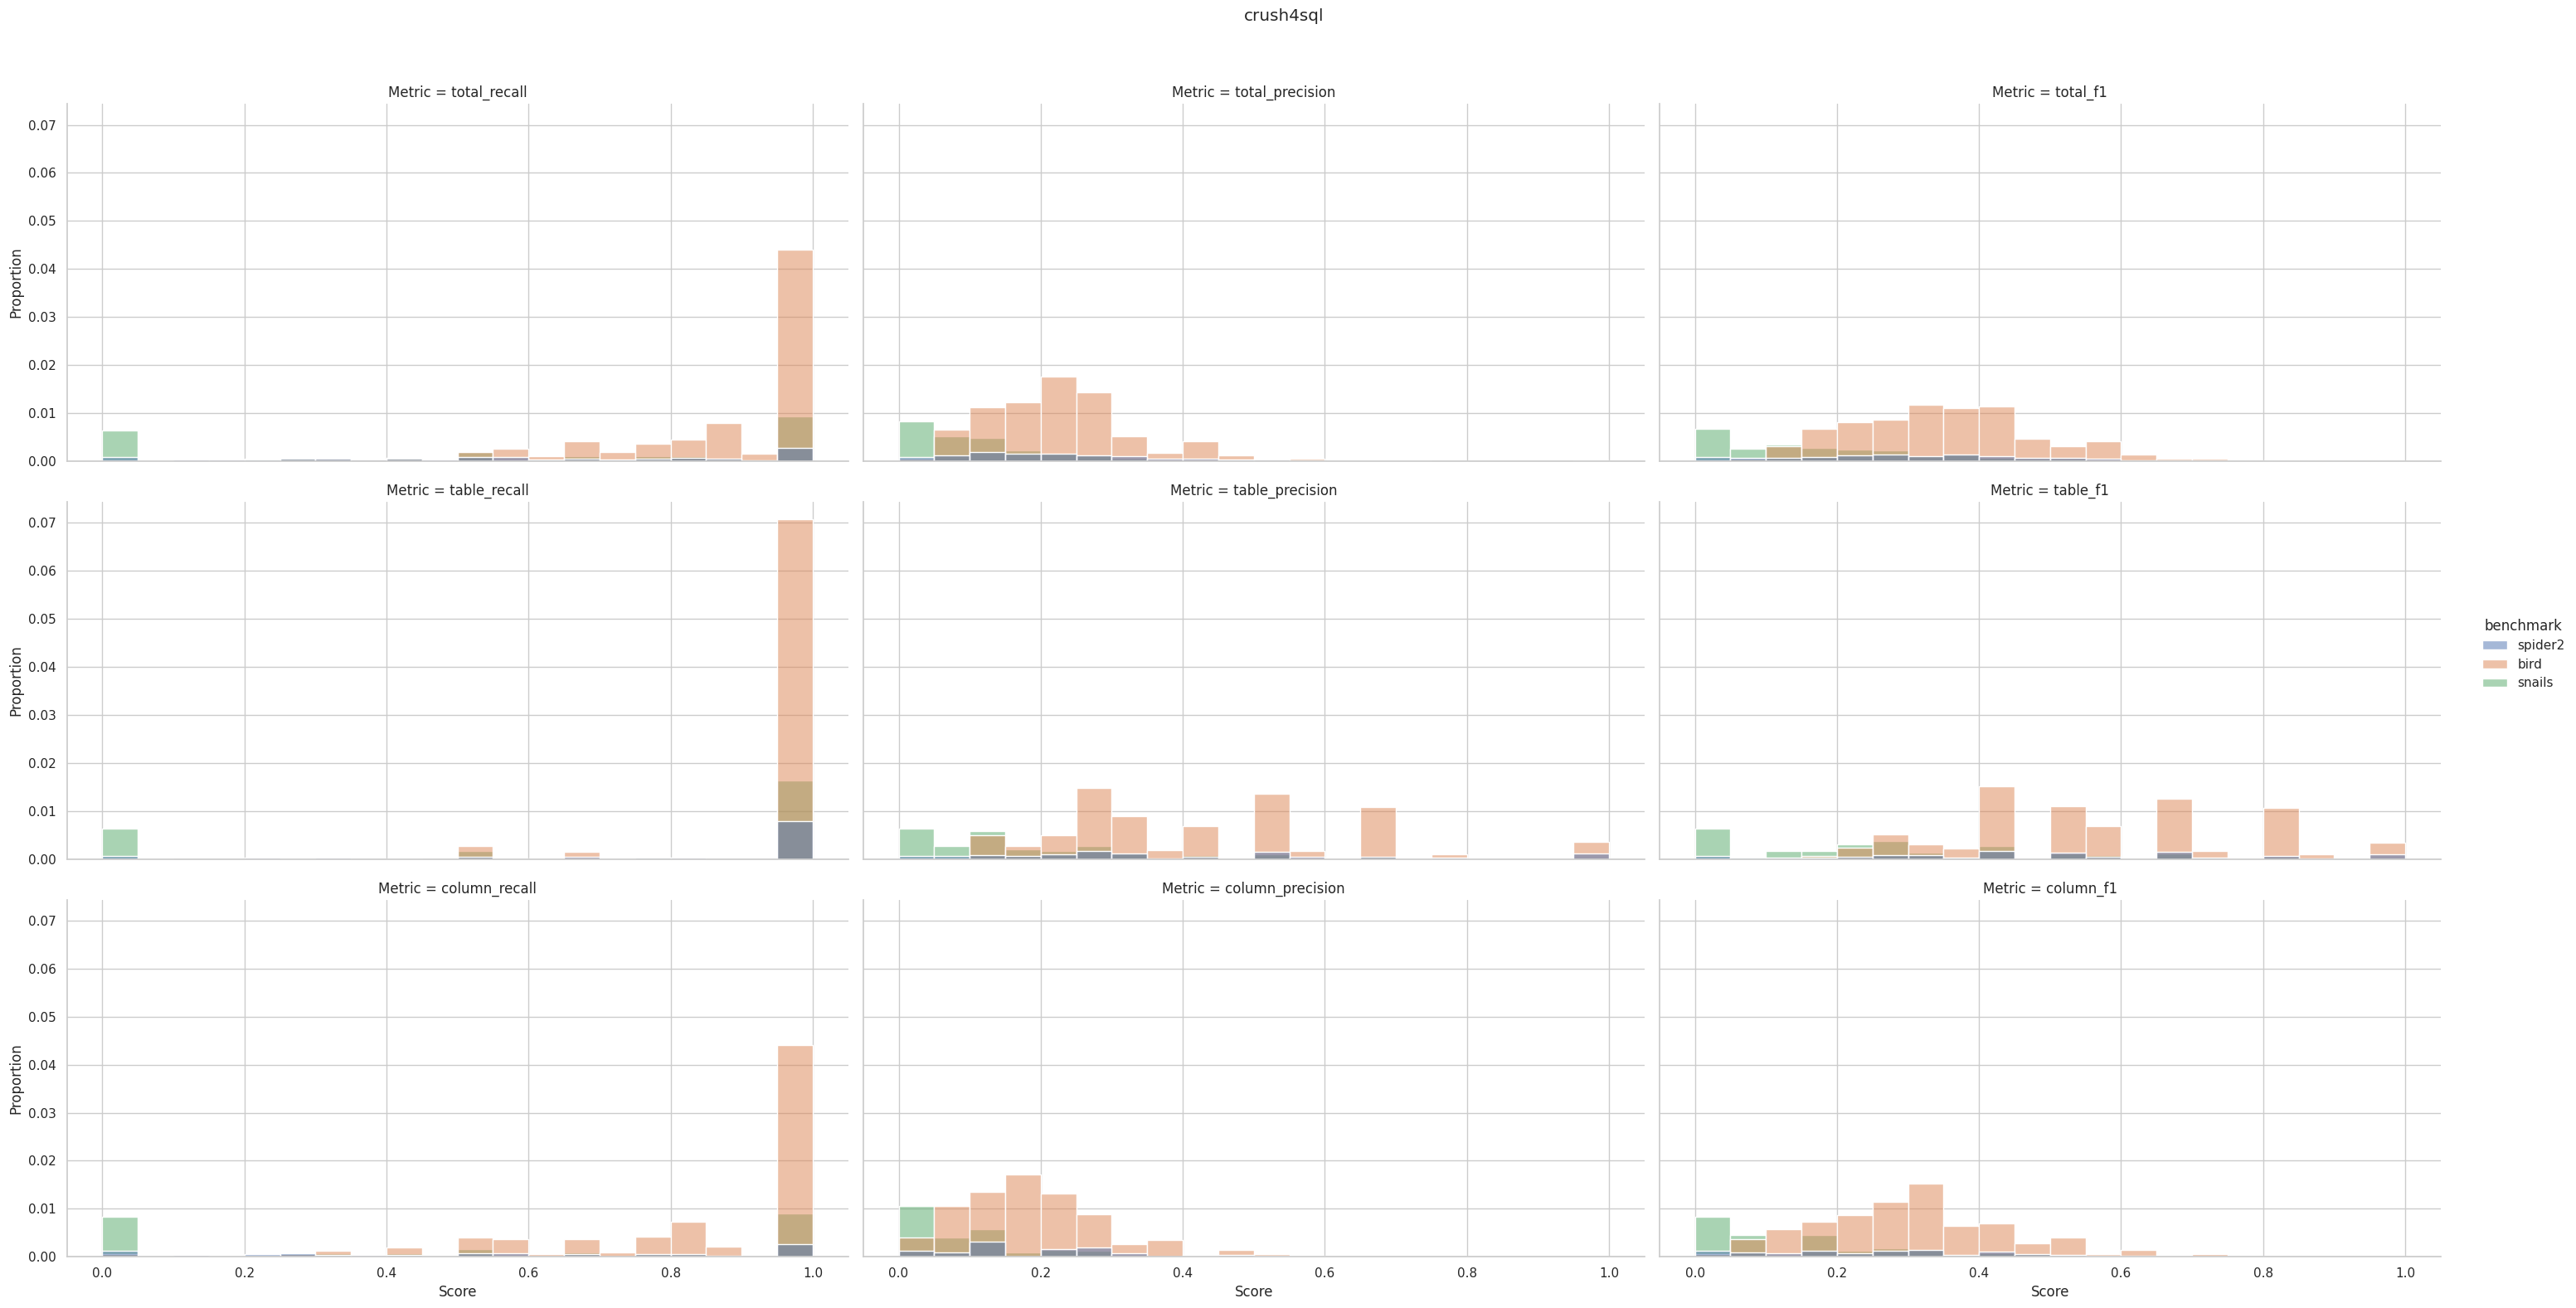

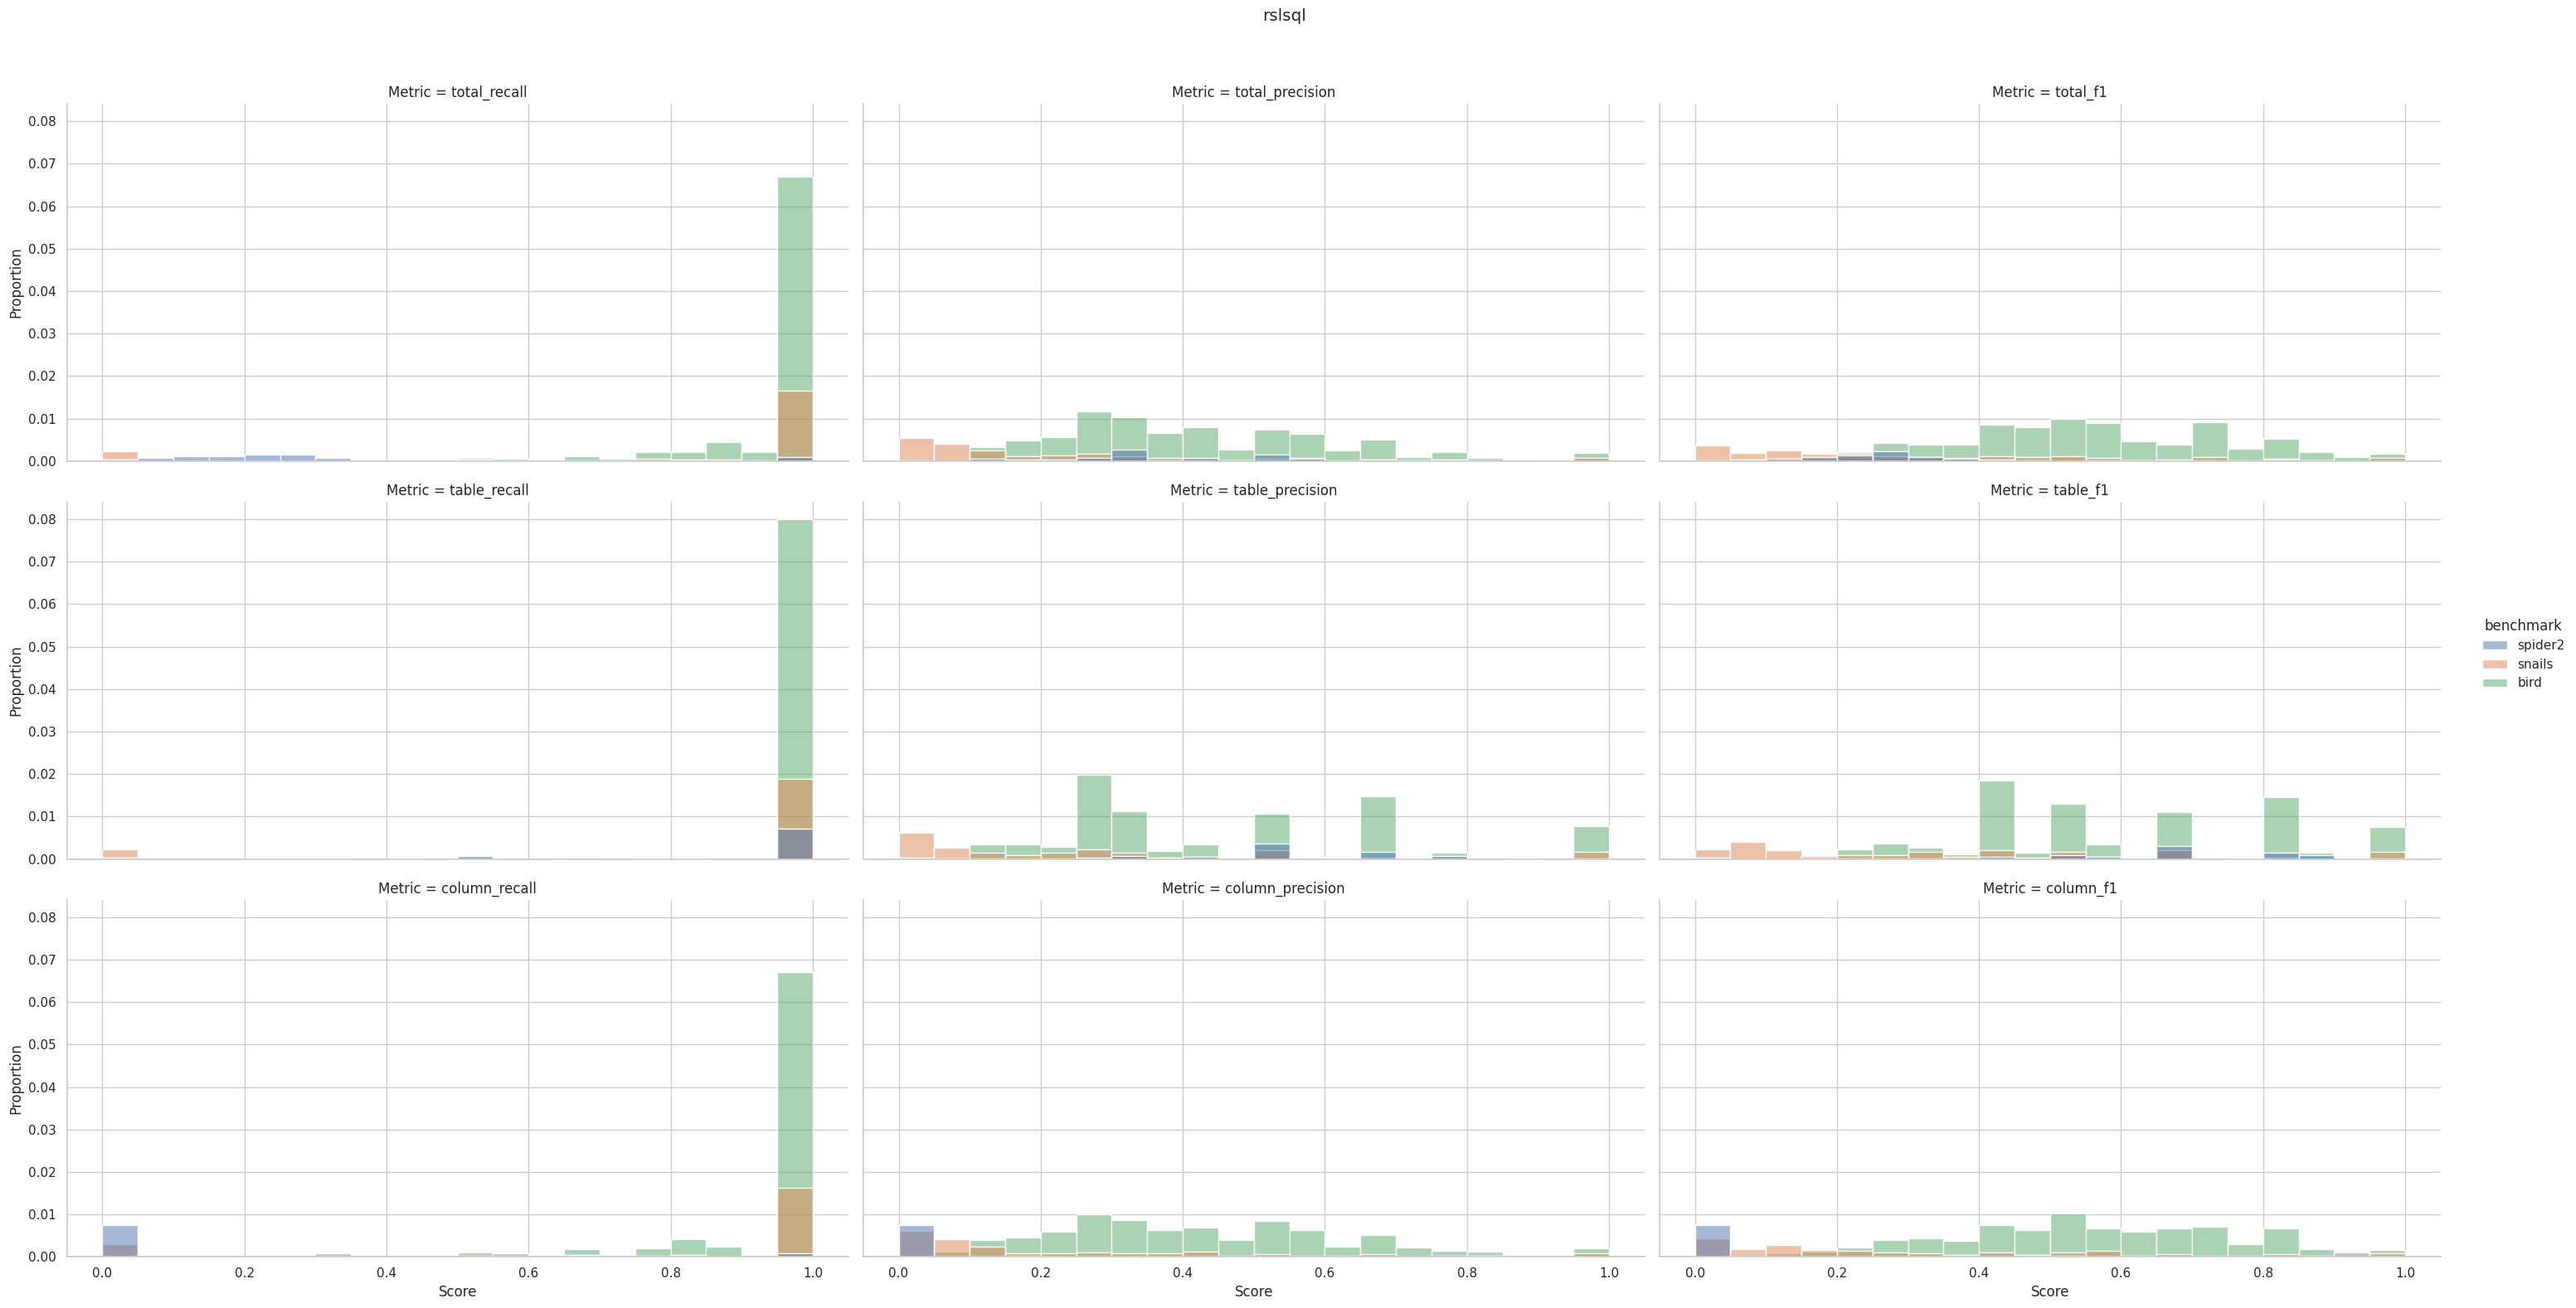

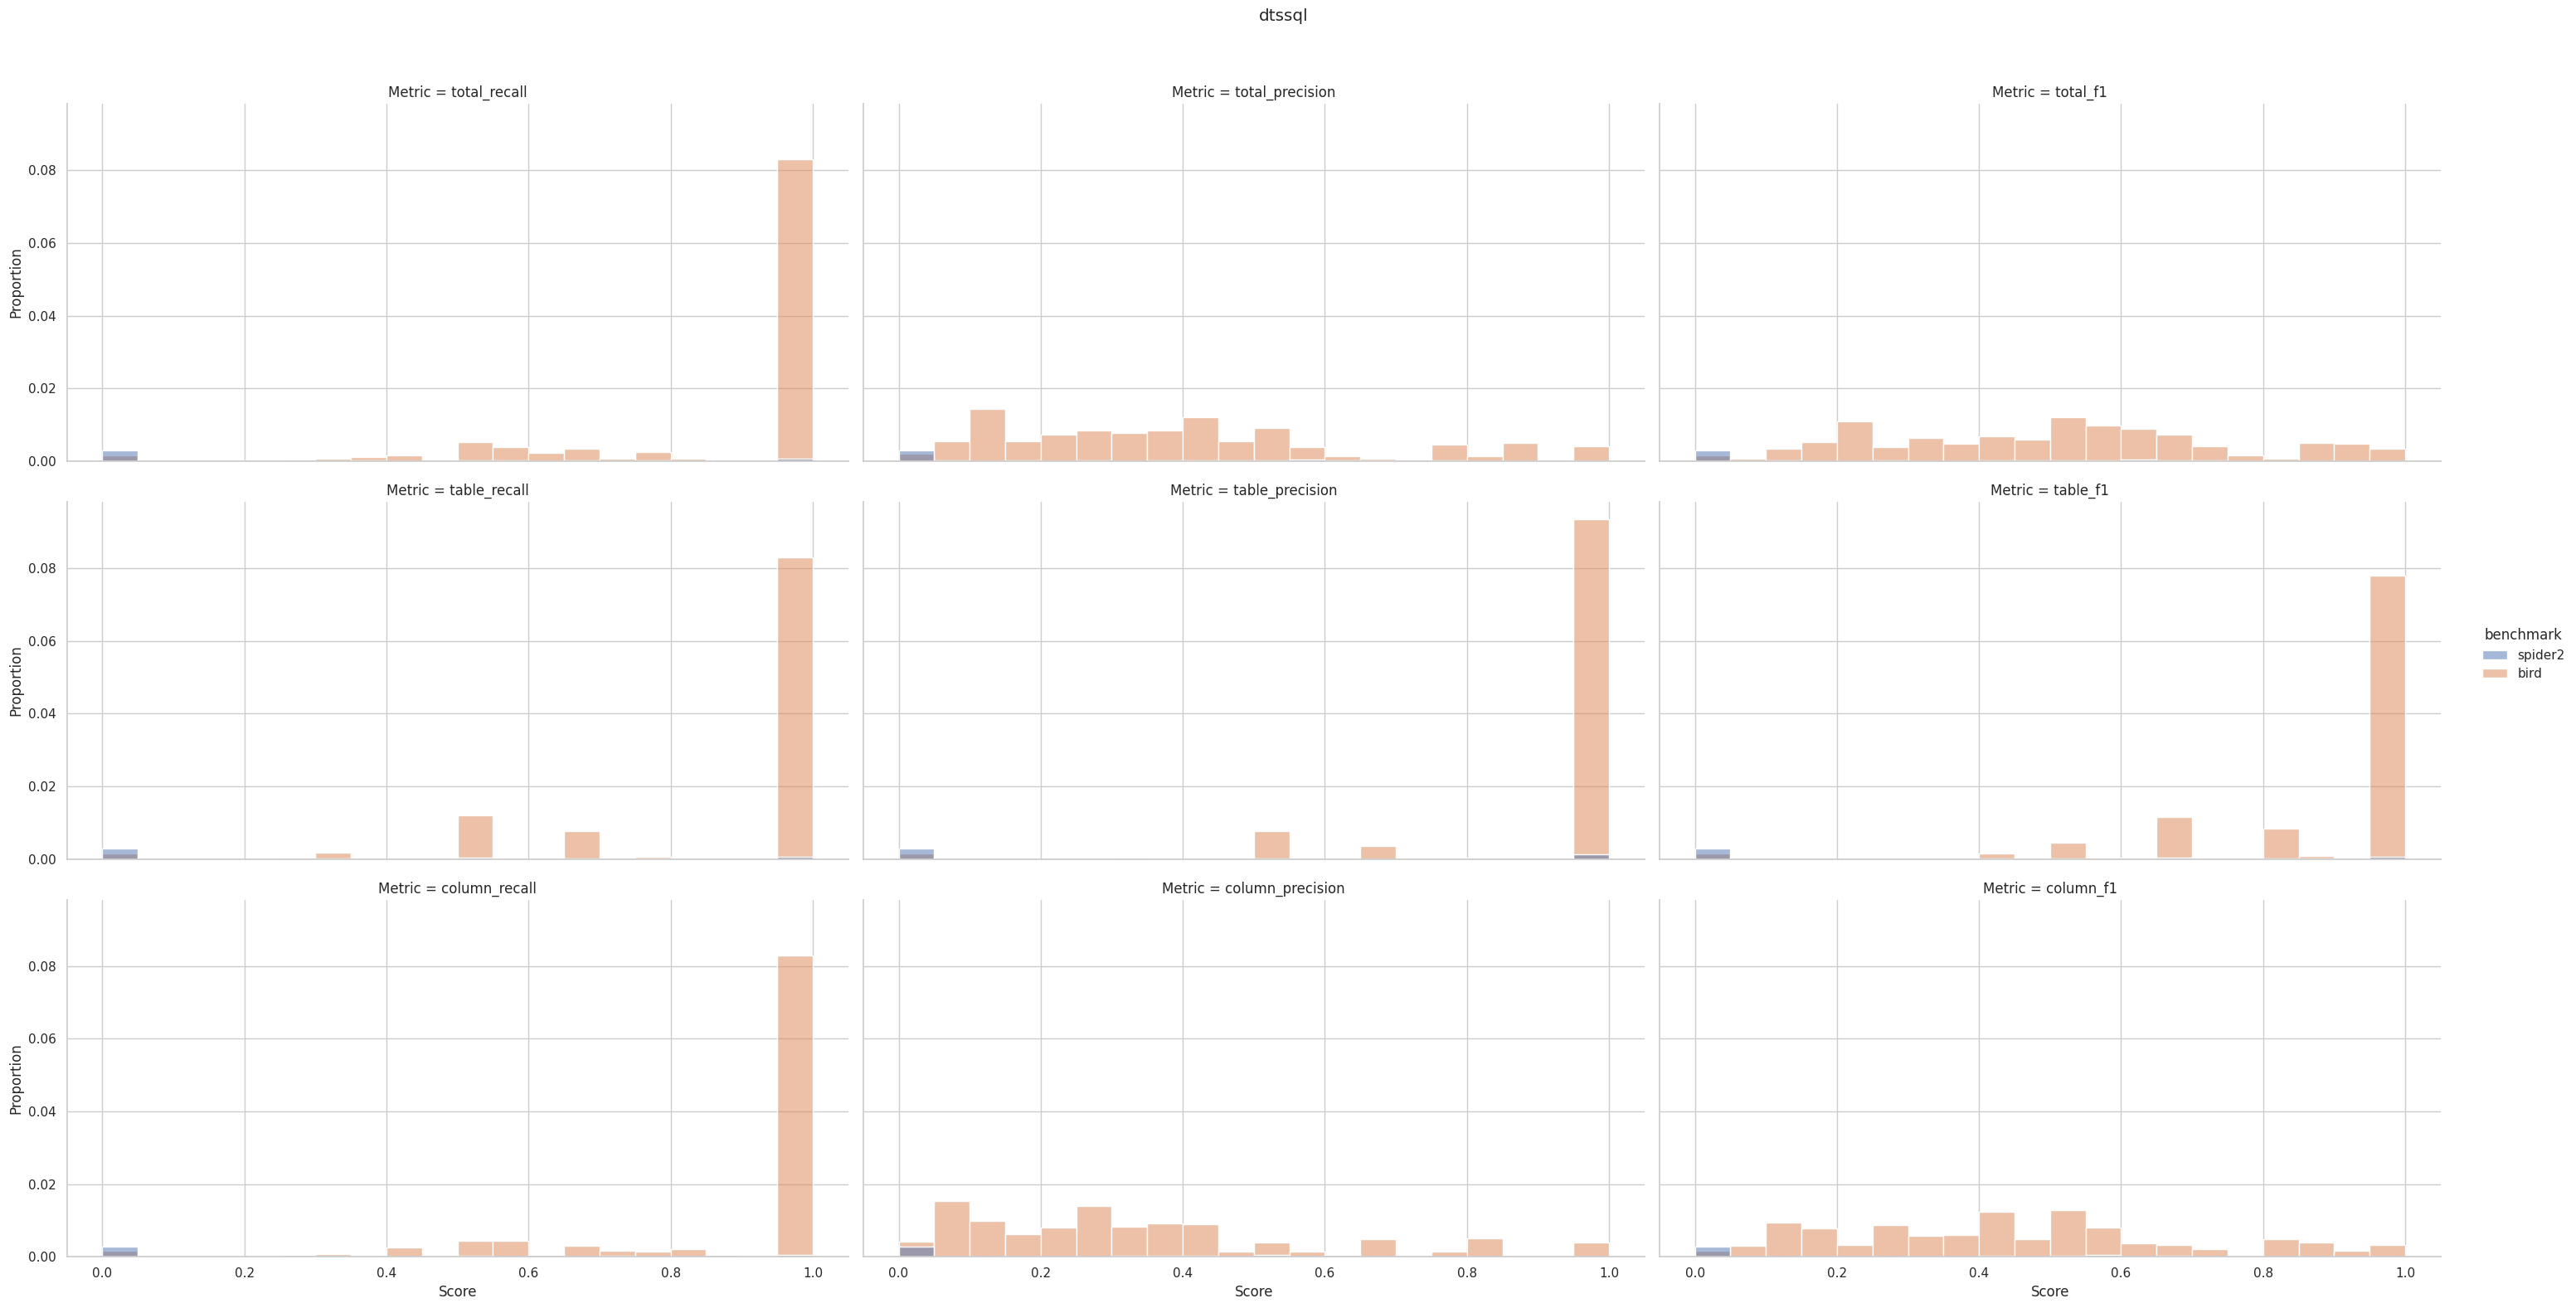

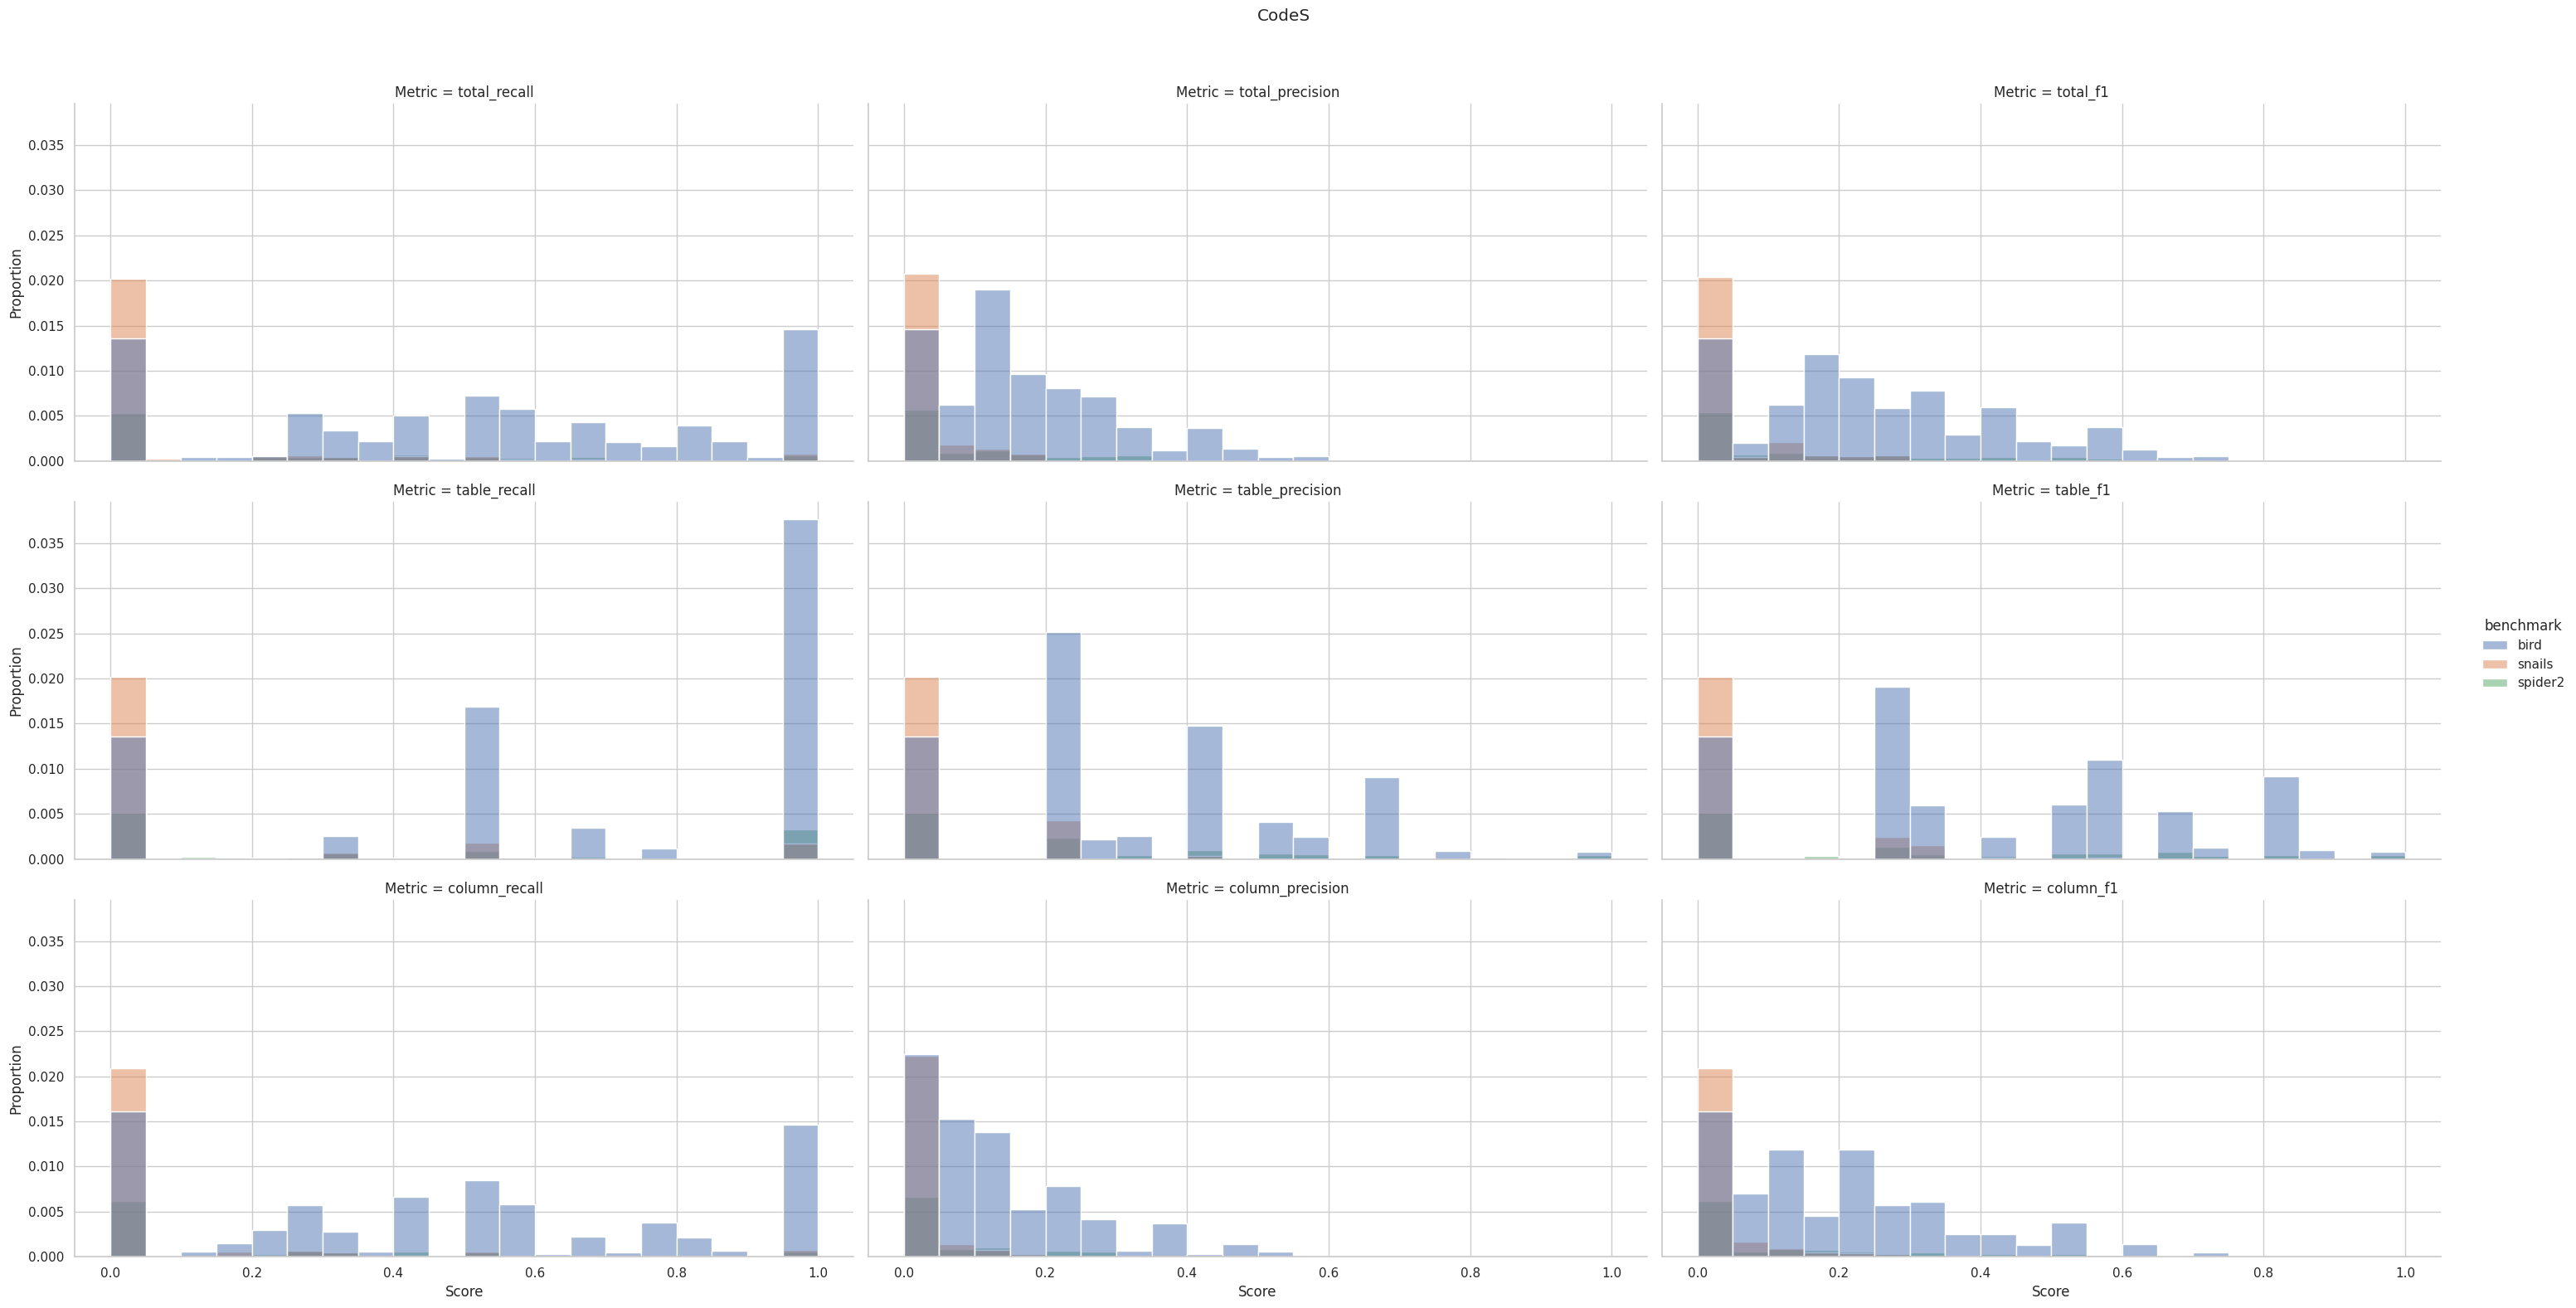

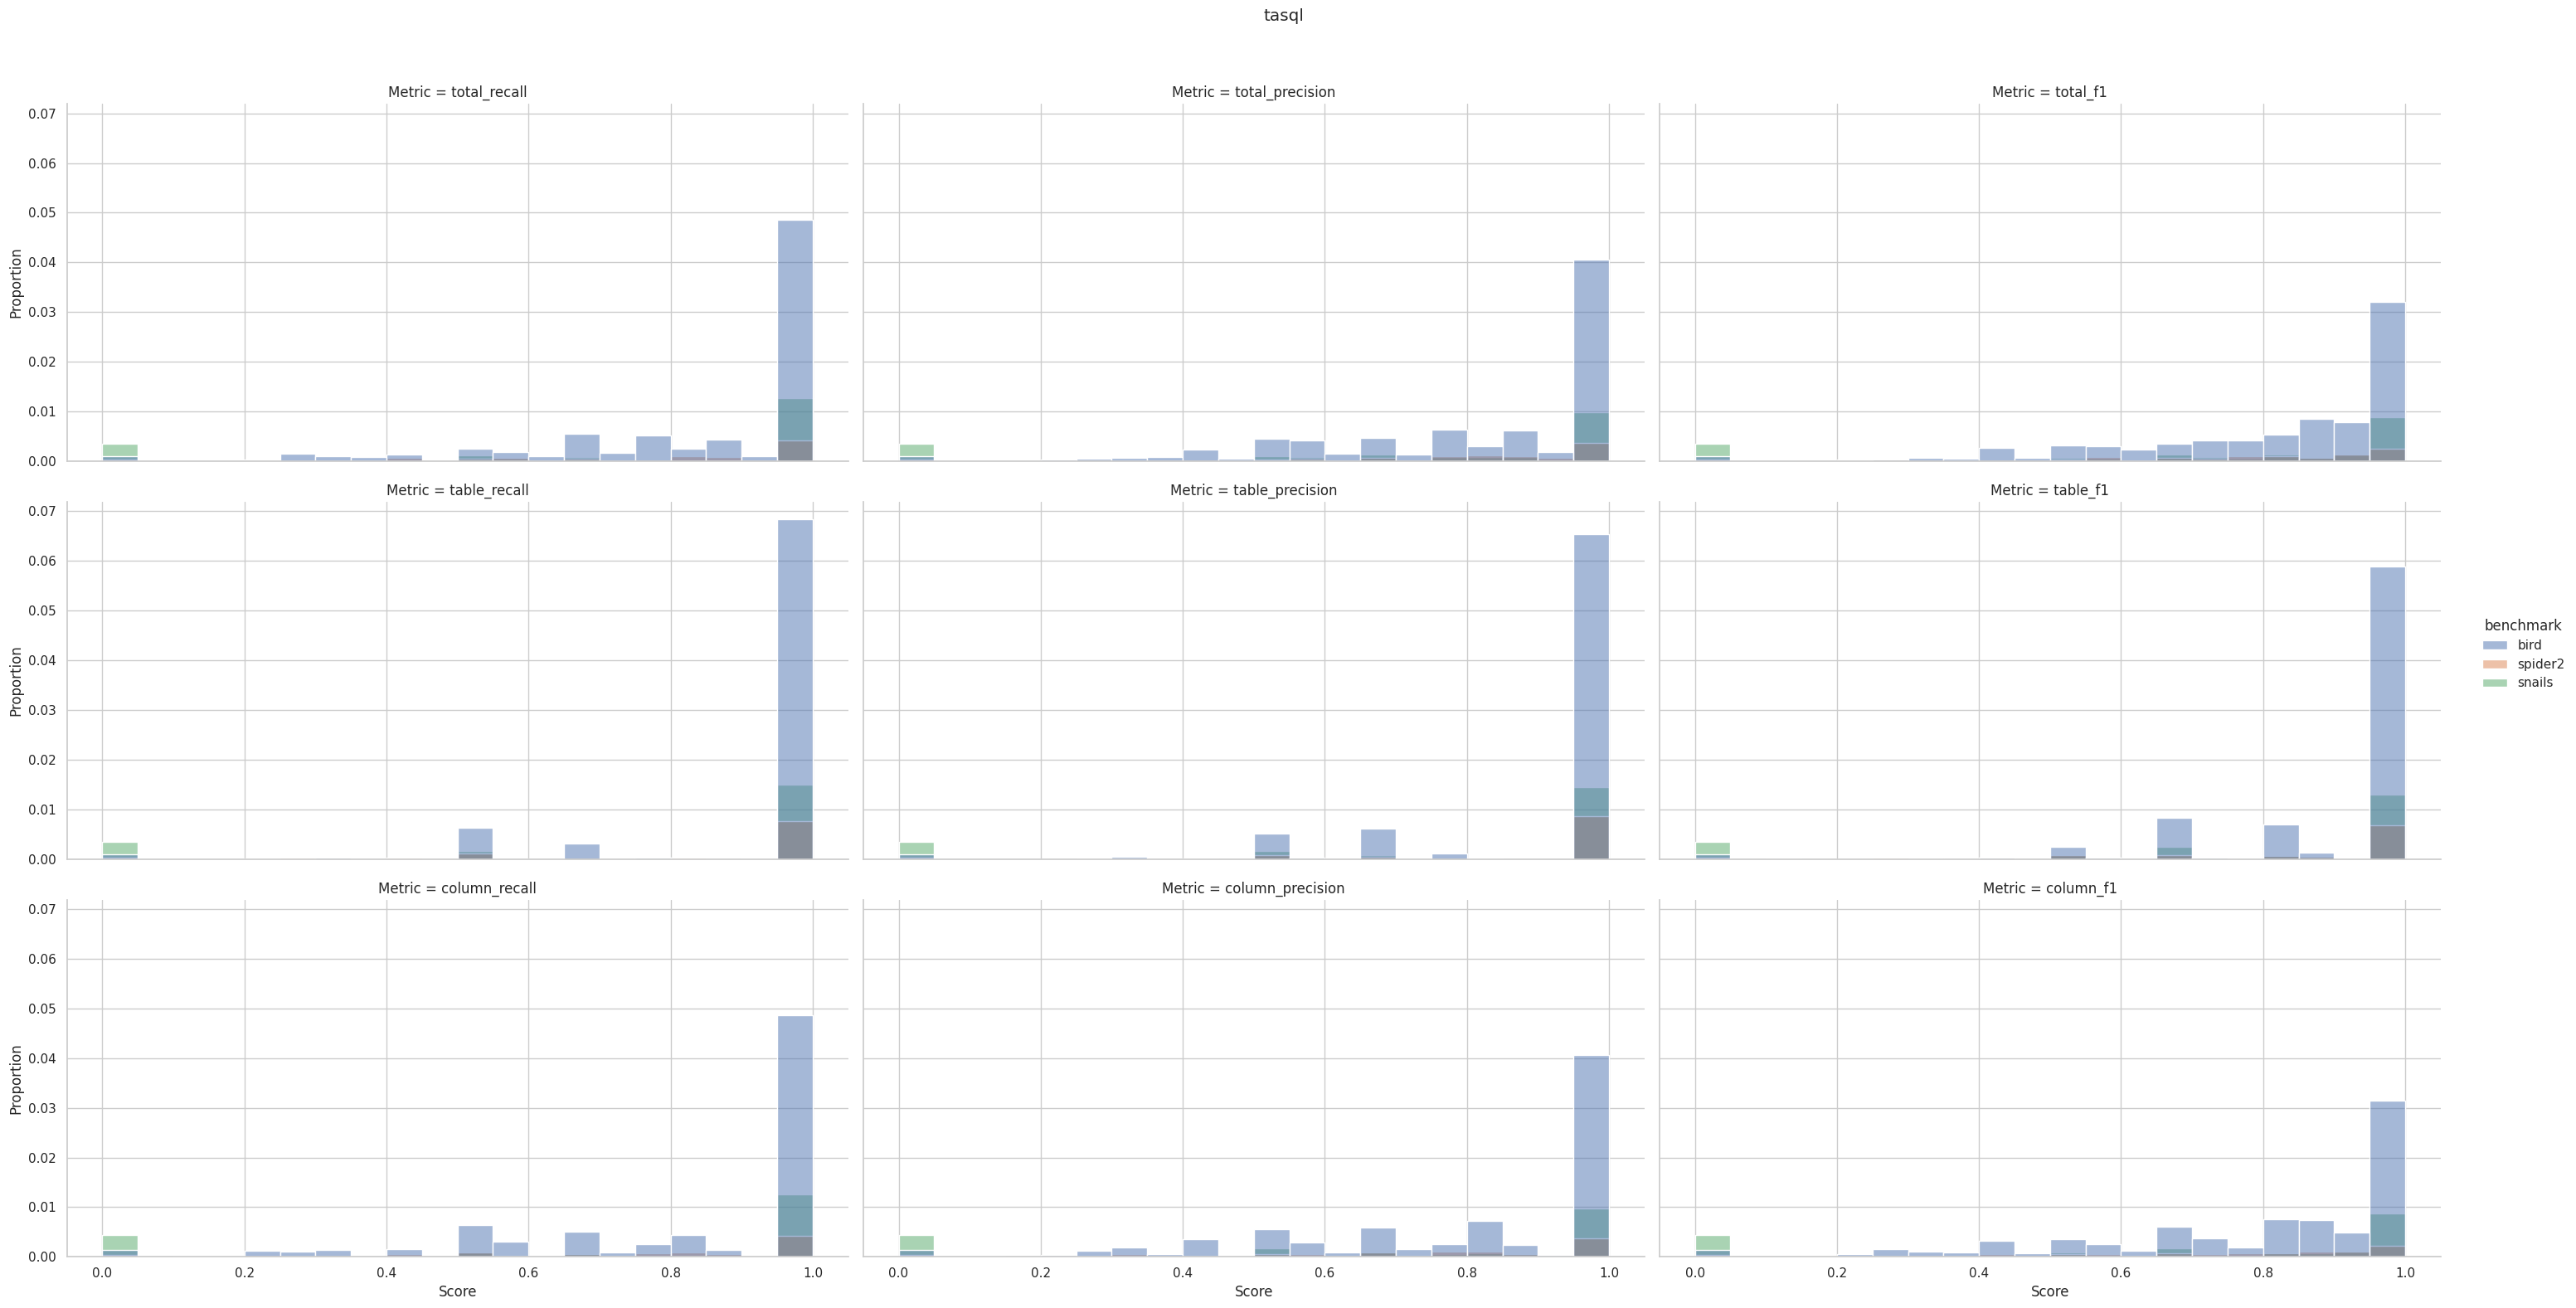

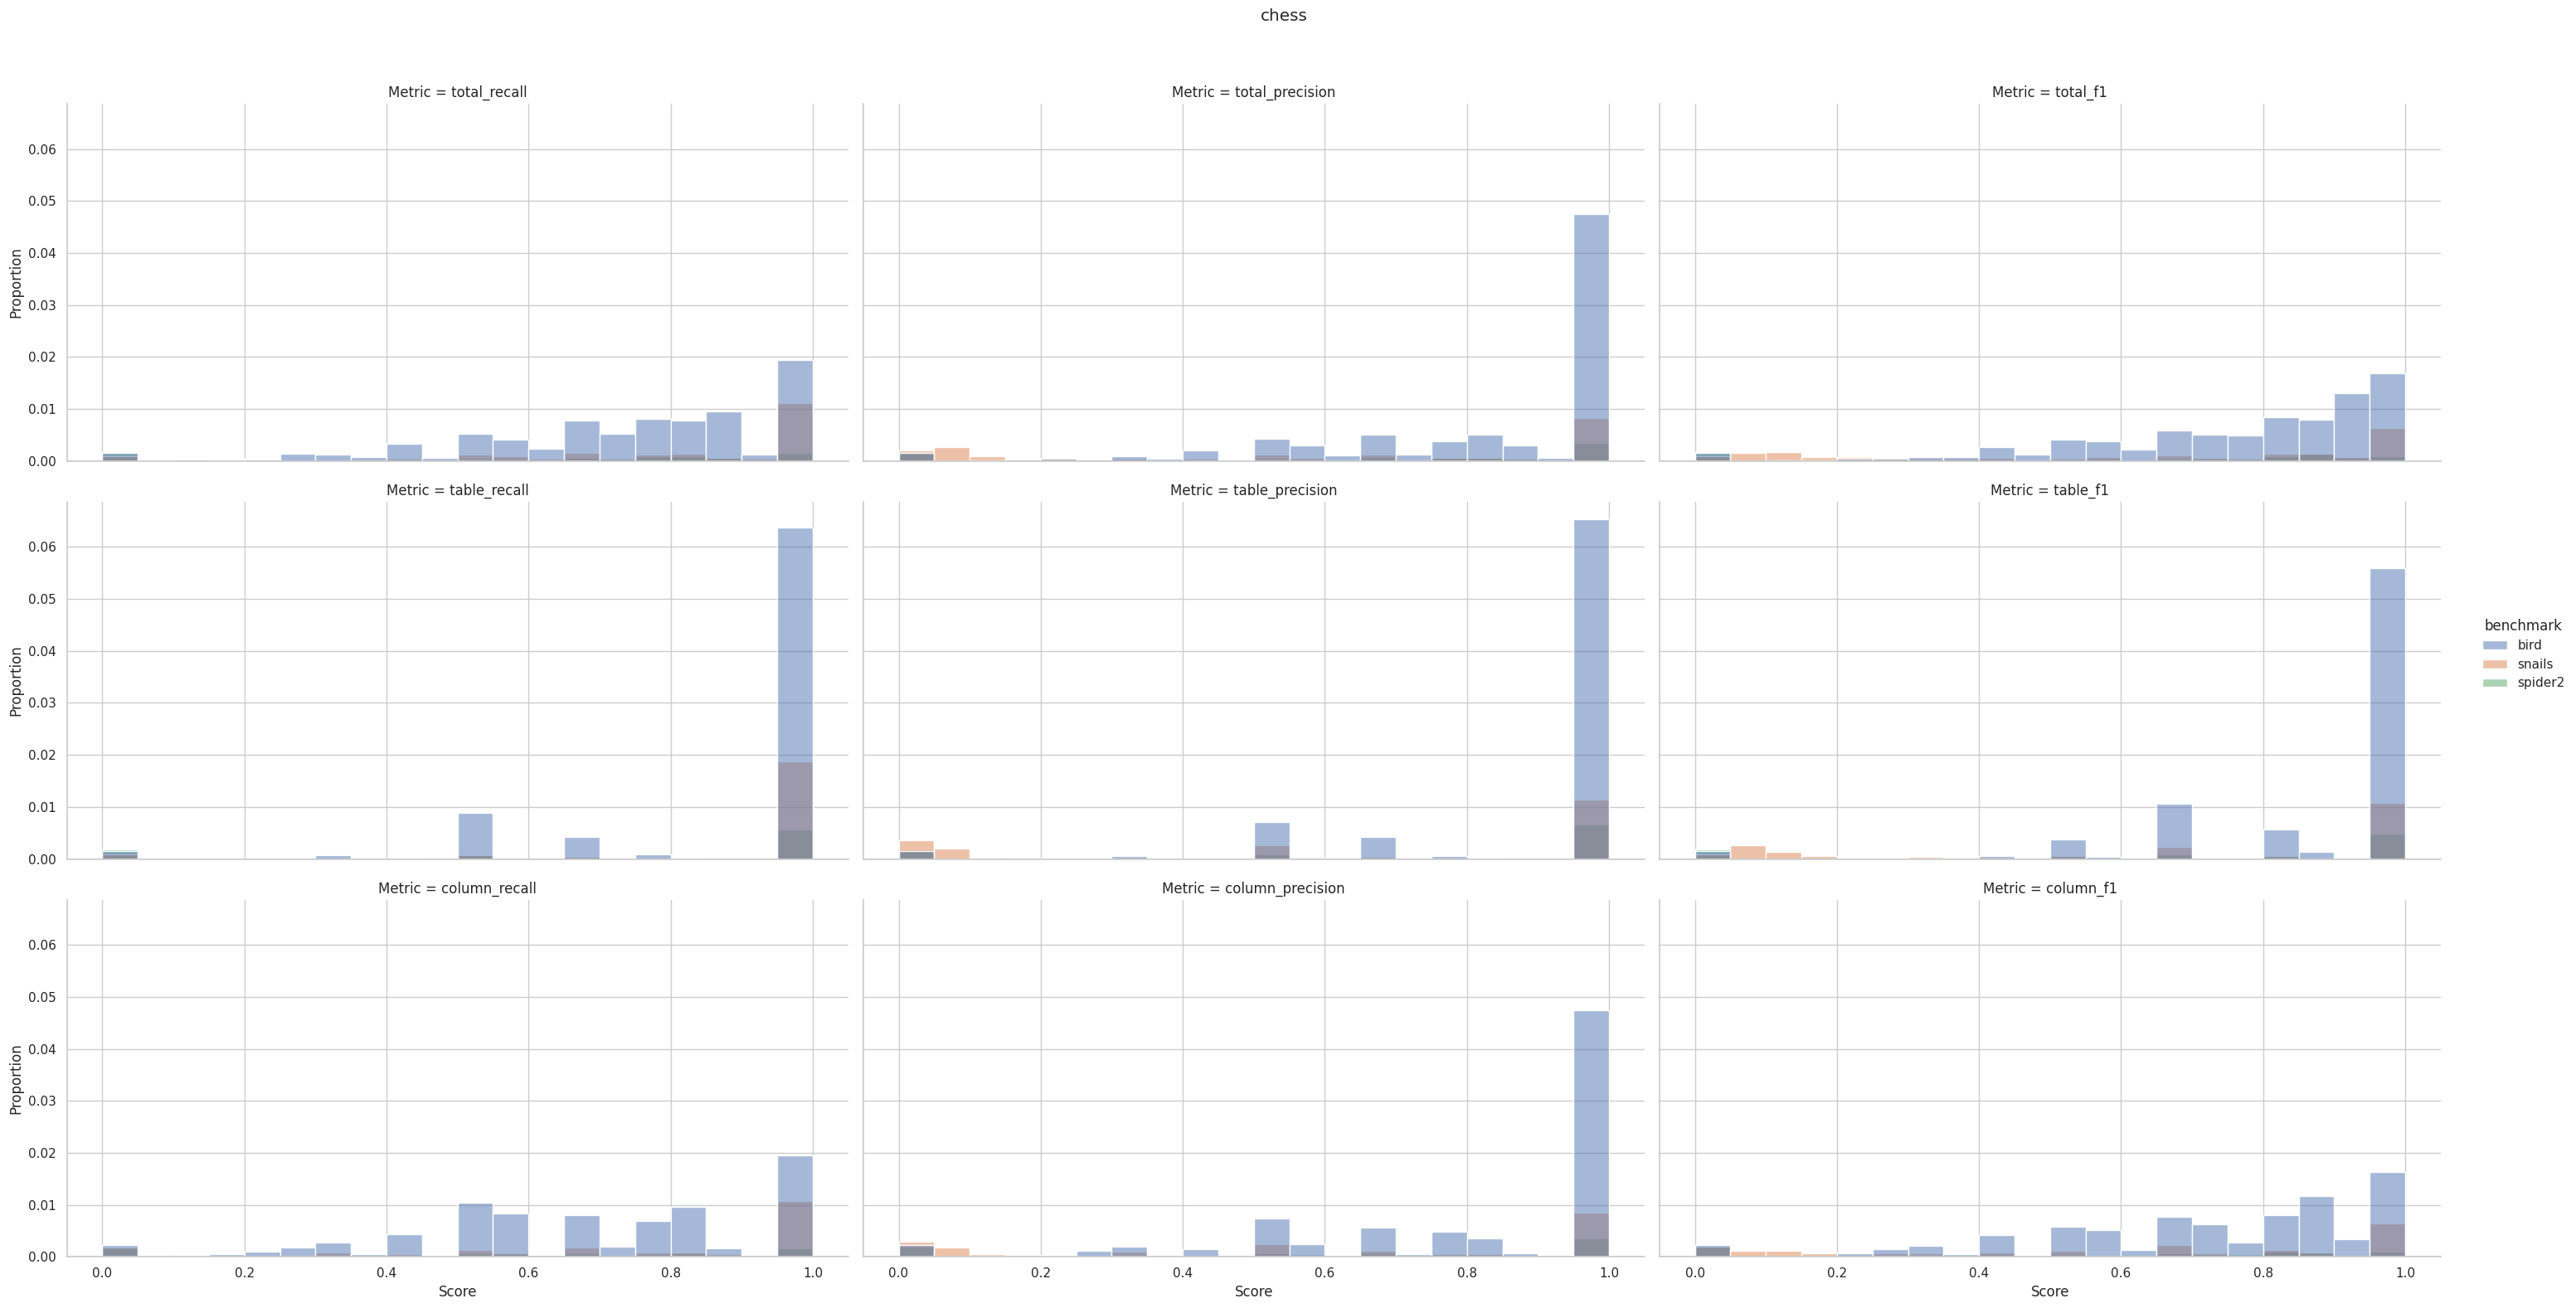

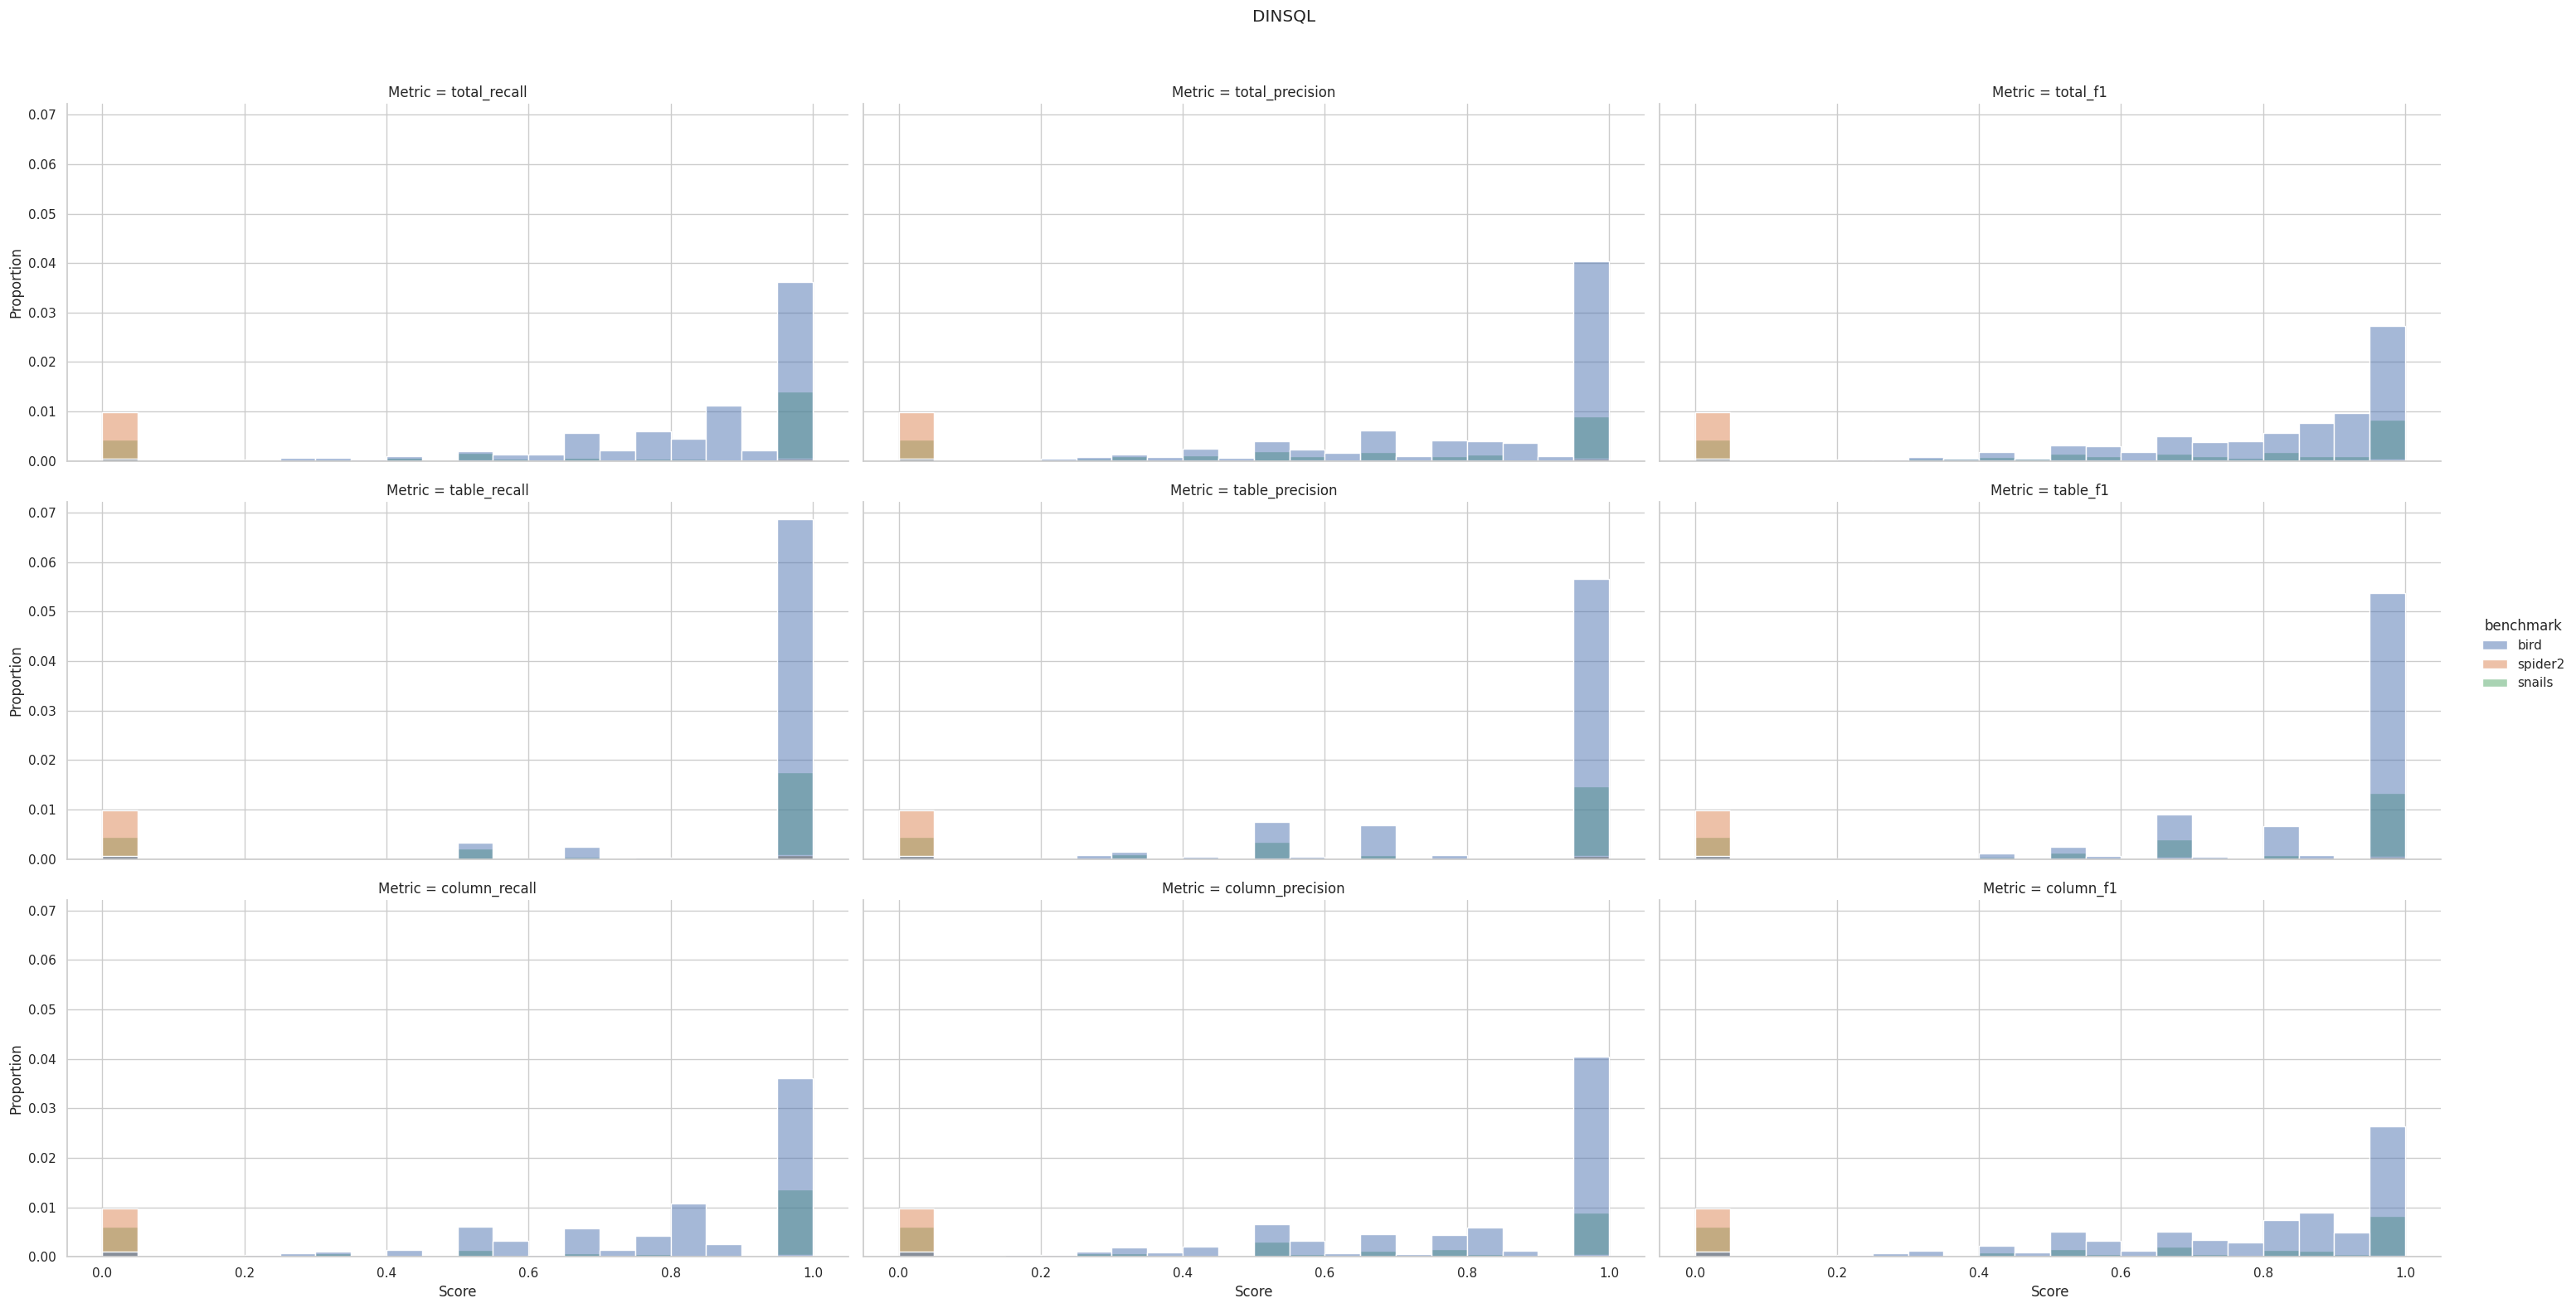

In [368]:
for sm in performance_df.subsetting_method.unique():
    g = sns.displot(
        data=performance_df.query(f"subsetting_method=='{sm}' and prompt_tokens>=0 and eval_model").melt(
            id_vars=["benchmark", "subsetting_method"],
            value_vars=[
                "total_recall", "total_precision", "total_f1", 
                "table_recall", "table_precision", "table_f1",
                "column_recall", "column_precision", "column_f1"
                ],
            value_name="Score",
            var_name="Metric"
        ),
        x="Score",
        hue="benchmark",
        kind="hist",
        stat="proportion",
        aspect=2,
        col="Metric",
        col_wrap=3,
        bins=20
    )
    g.figure.suptitle(sm, y=1.05)

## Diagnosis

### Hidden tables and ambiguous extra table counts by subsetting method

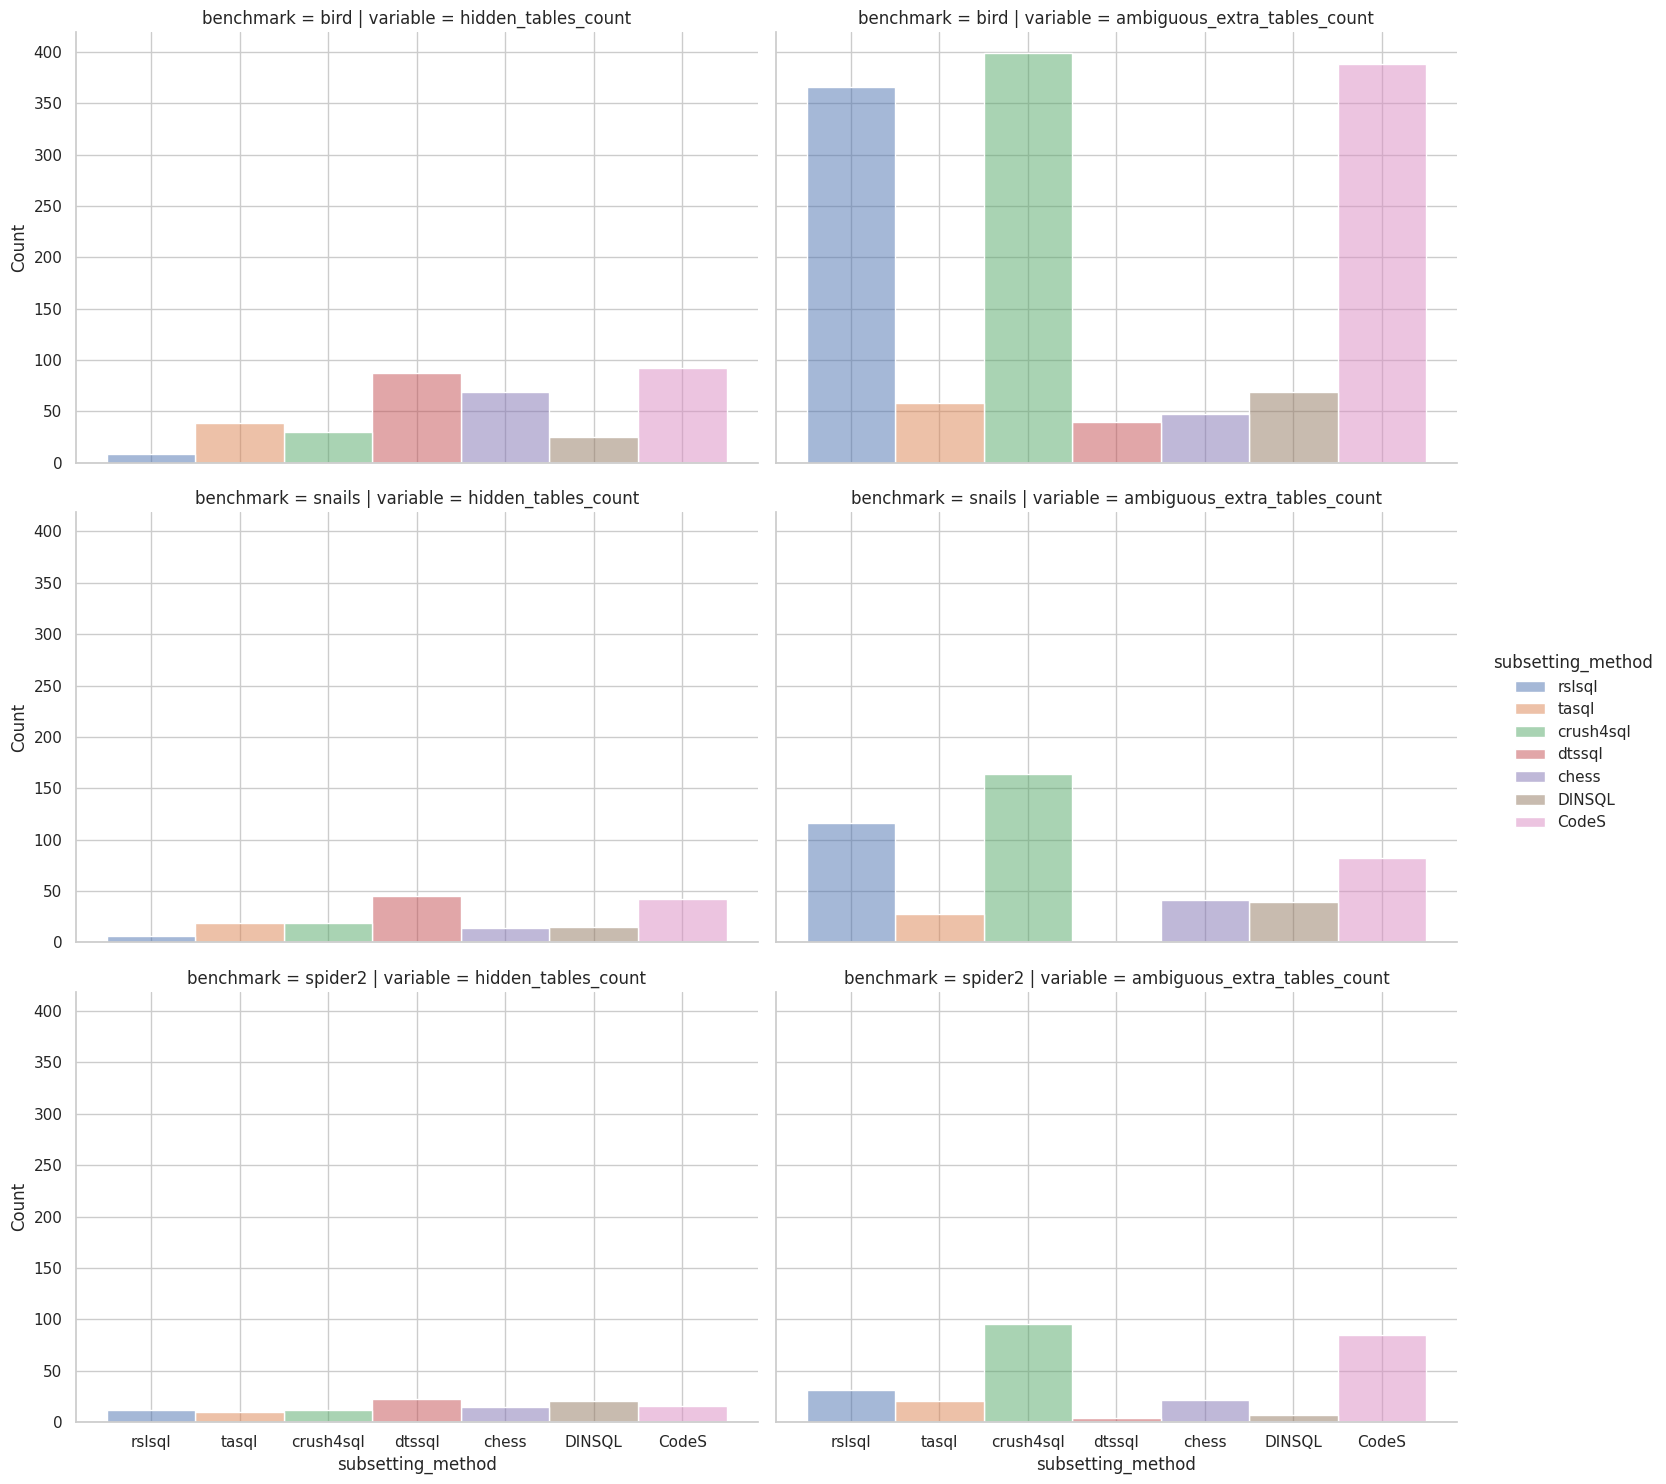

In [369]:
temp_data_df = diagnosis_df.query("eval_model").melt(
    id_vars=["benchmark", "database", "question_number", "comments", "subsetting_method"],
    value_vars=[c_name for c_name in diagnosis_df.columns if "_count" in c_name and "table" in c_name and "missing" not in c_name]
).query("value>0")
g = sns.displot(
    data=temp_data_df,
    x="subsetting_method",
    col="variable",
    # col_wrap=2,
    hue="subsetting_method",
    row="benchmark",
    aspect=1.5
)

### Value reference problem columns and ambiguous extra column counts by subsetting method

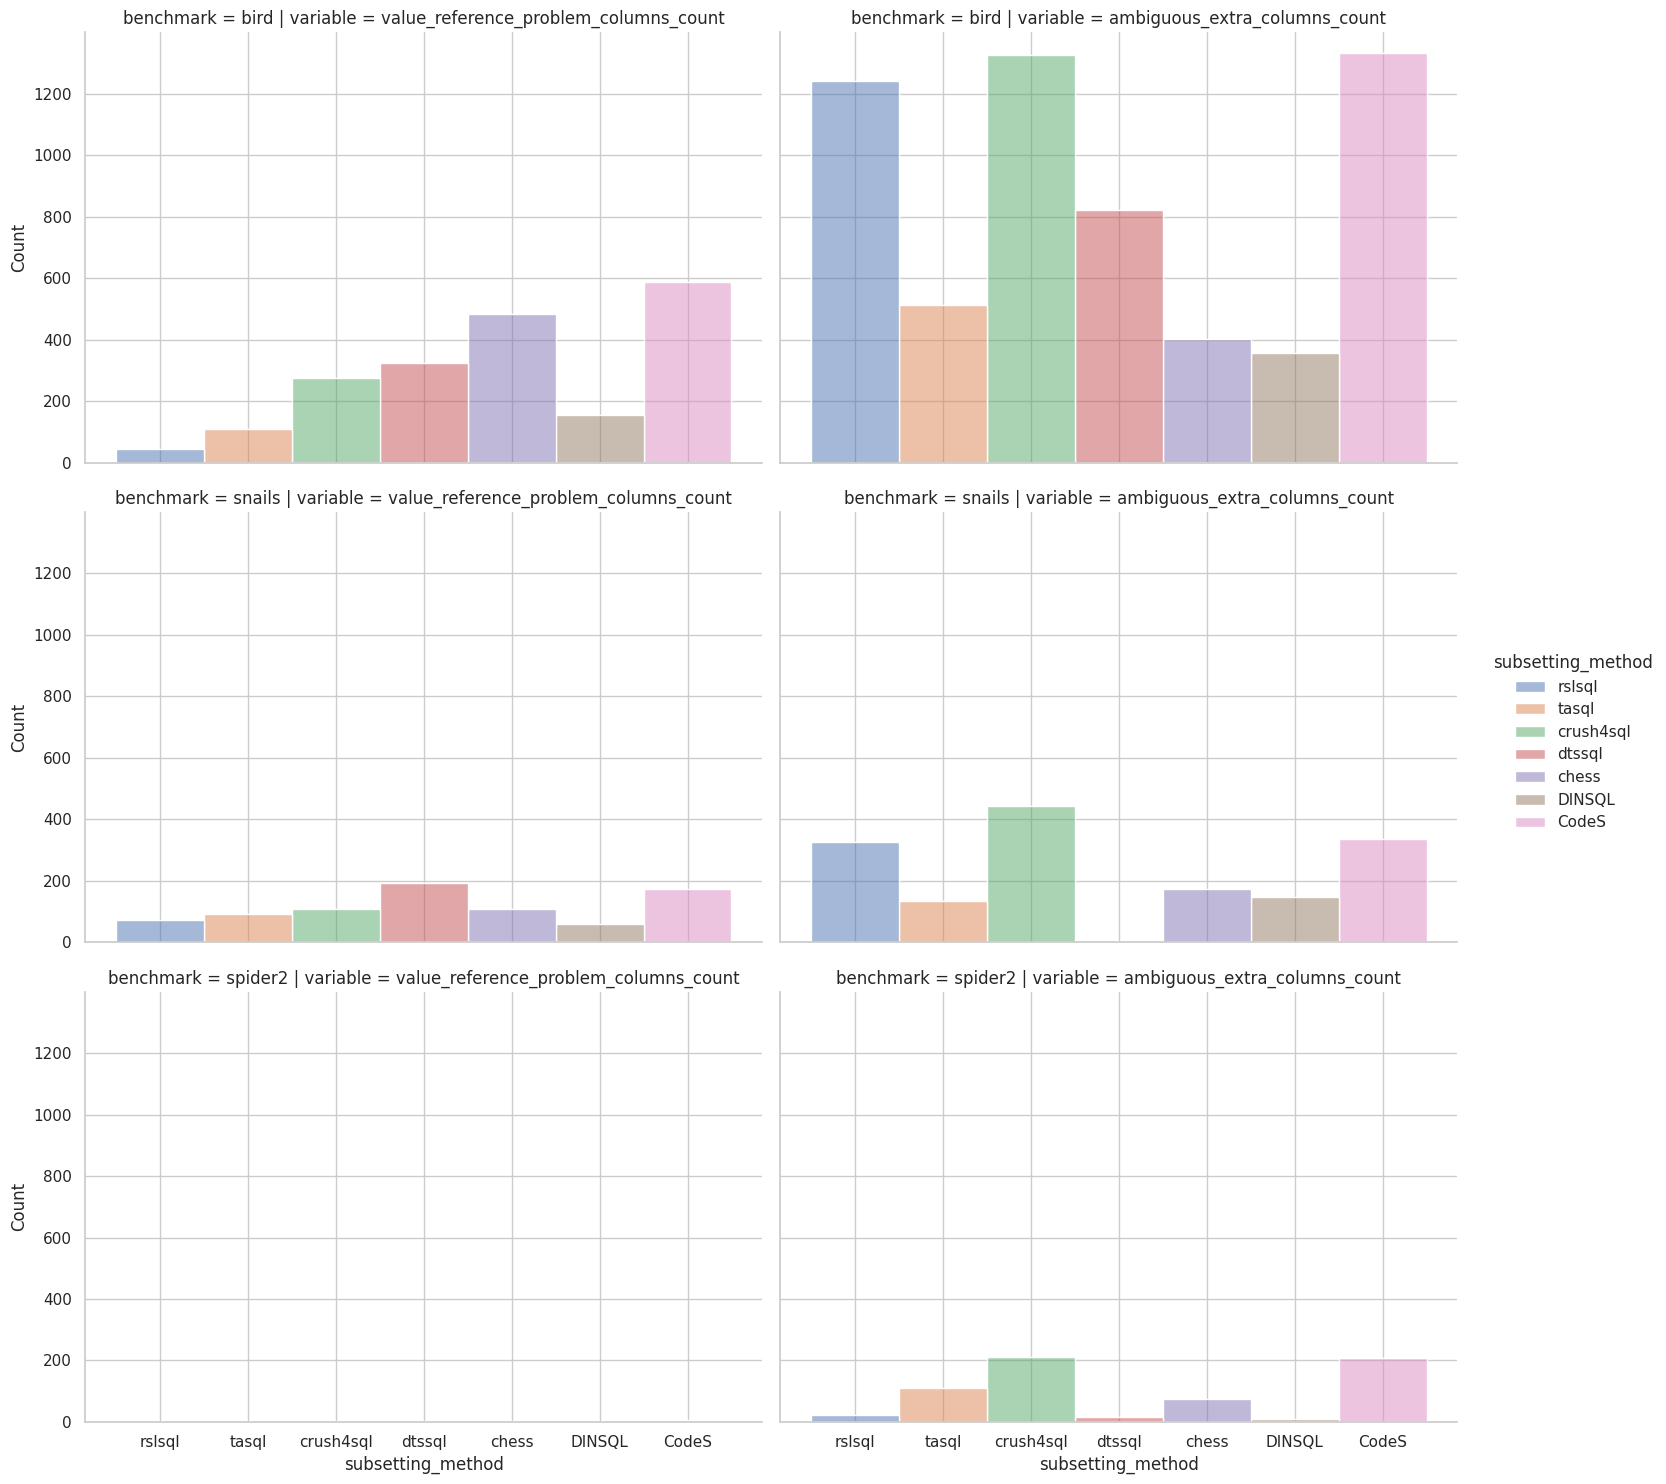

In [370]:
temp_data_df = diagnosis_df.query("eval_model").melt(
    id_vars=["benchmark", "database", "question_number", "comments", "subsetting_method"],
    value_vars=[c_name for c_name in diagnosis_df.columns if "_count" in c_name and "column" in c_name and "missing" not in c_name]
).query("value>0")
g = sns.displot(
    data=temp_data_df,
    x="subsetting_method",
    col="variable",
    # col_wrap=2,
    hue="subsetting_method",
    row="benchmark",
    aspect=1.5
)

### Diagnosis categories for each subsetting method

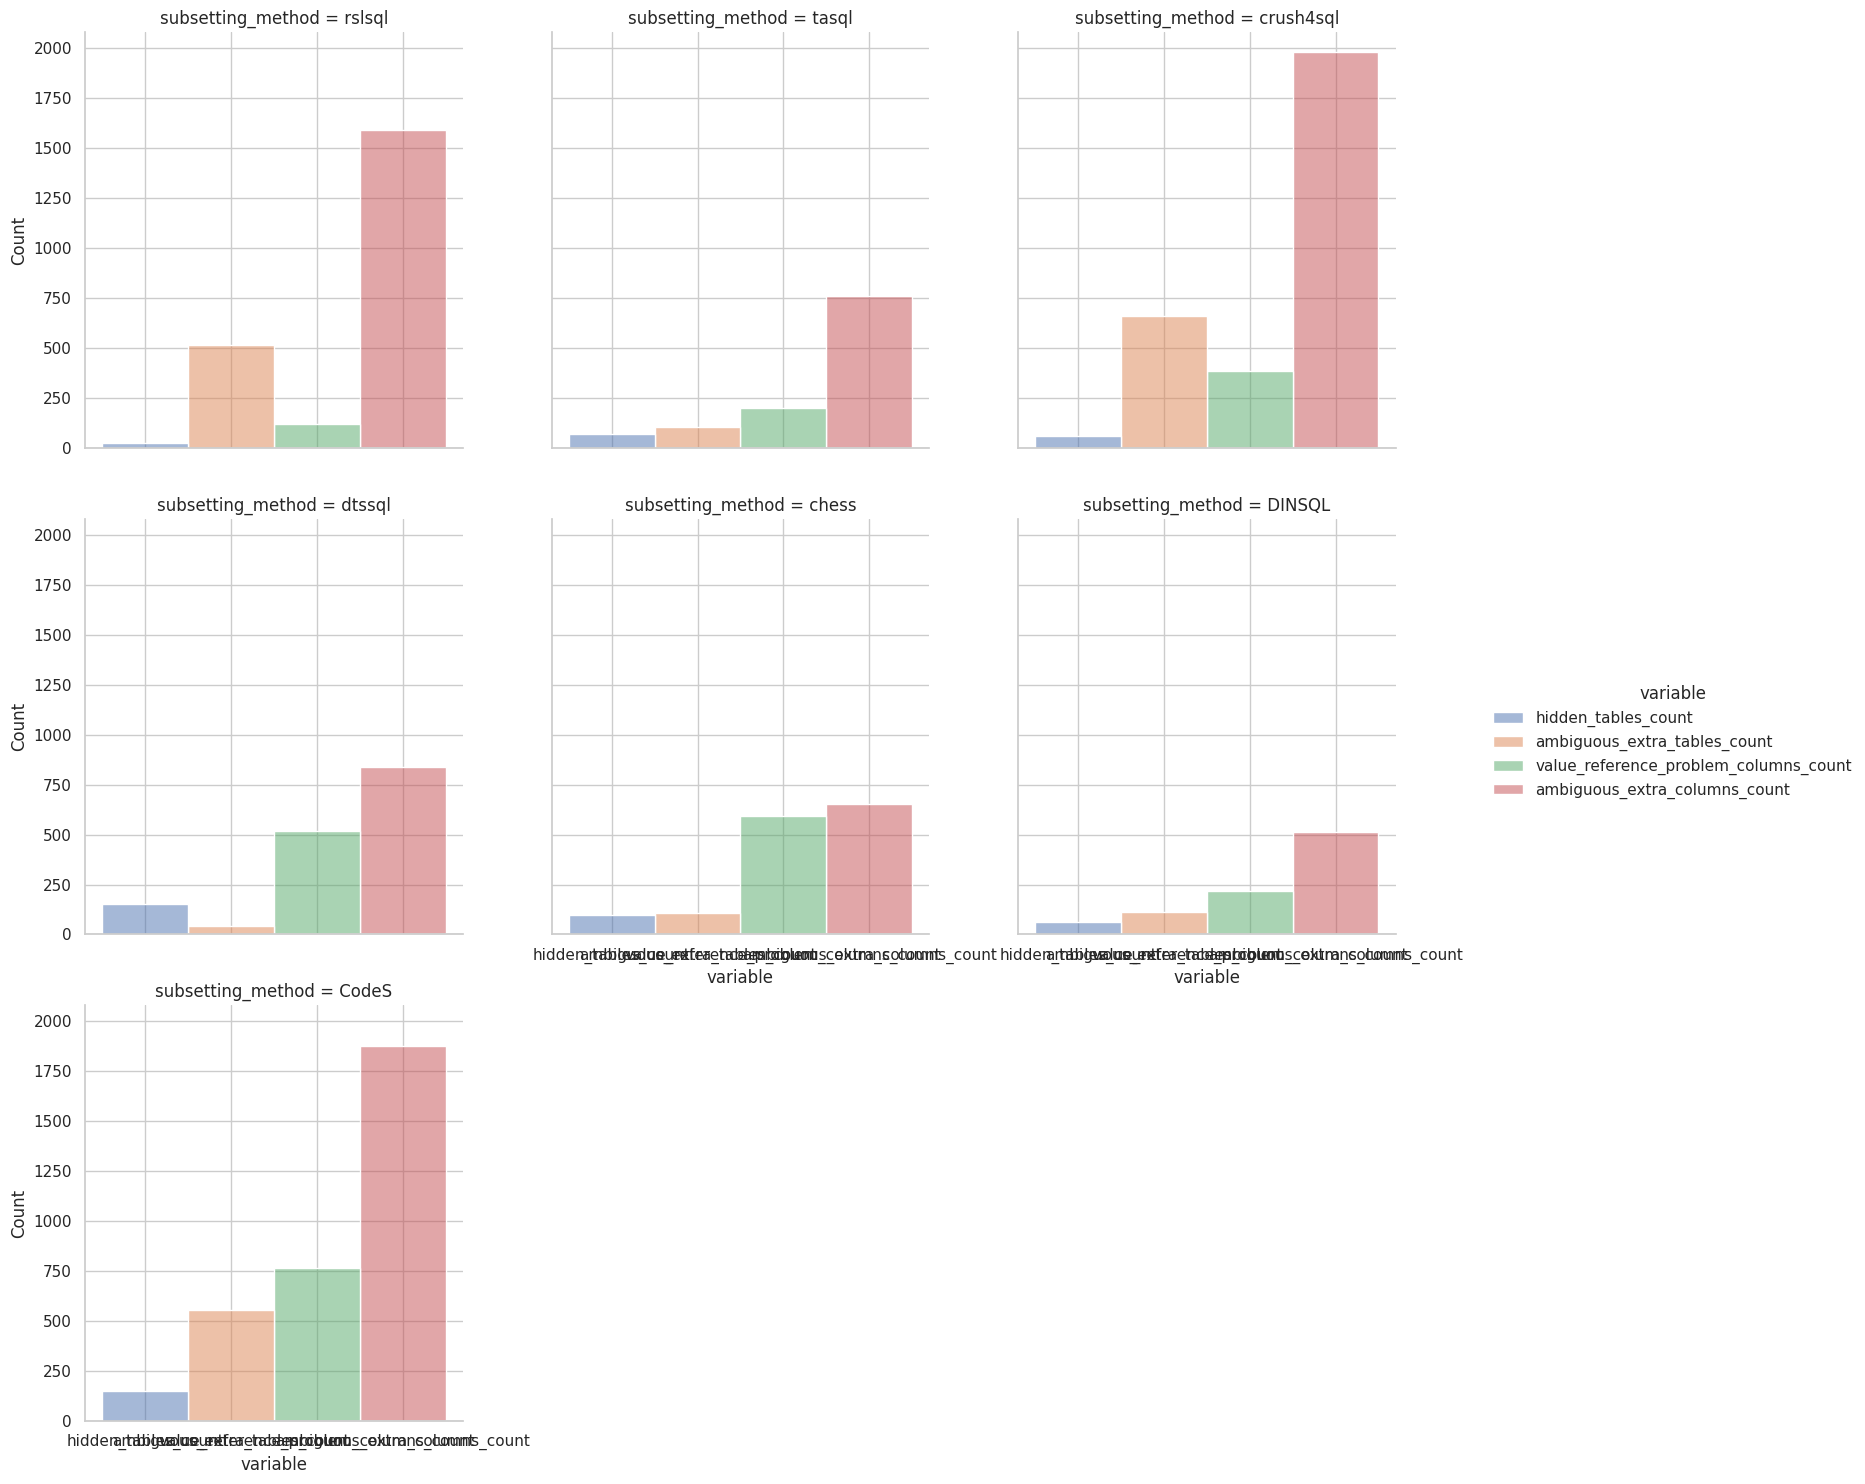

In [371]:
temp_data_df = diagnosis_df.query("eval_model").melt(
    id_vars=["benchmark", "database", "question_number", "comments", "subsetting_method"],
    value_vars=[c_name for c_name in diagnosis_df.columns if "_count" in c_name and "missing" not in c_name]
).query("value>0")
g = sns.displot(
    data=temp_data_df,
    x="variable",
    col="subsetting_method",
    col_wrap=3,
    hue="variable",
    aspect=1
)


## Schema Processing 

### Seconds per Column by subsetting method Histogram

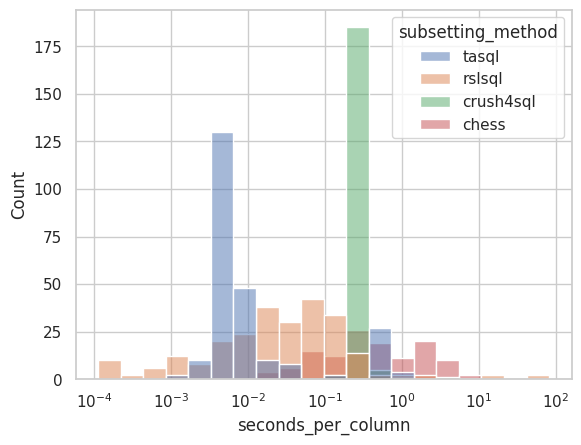

In [372]:
g = sns.histplot(
    data=processing_time_df,
    x="seconds_per_column",
    bins=20,
    log_scale=True,
    hue="subsetting_method"
)

### Processing Times by Method and Database Size

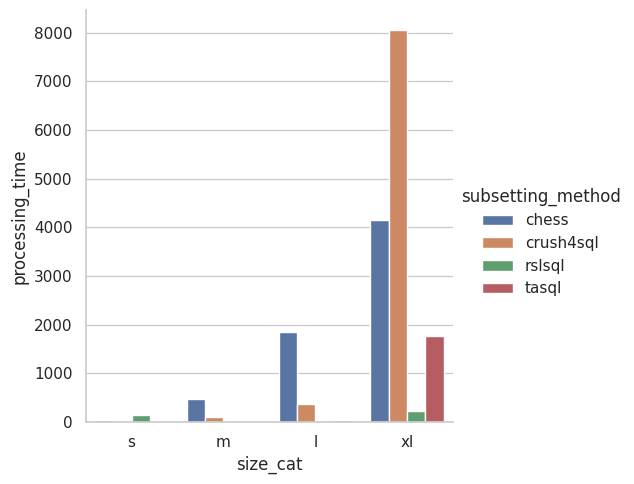

In [373]:
temp_data_df = processing_time_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()[["size_cat", "subsetting_method", "processing_time"]].groupby(
    ["size_cat", "subsetting_method"]
).mean().reset_index().sort_values(by="size_cat", key=lambda x:  x.map({"xs": 0, "s": 1, "m": 2, "l": 3, "xl": 4, "xxl": 5}))

g = sns.catplot(
    data=temp_data_df,
    x="size_cat",
    y="processing_time",
    hue="subsetting_method",
    kind="bar"
)

## Correlations

### Total Precision x Total Recall for each subsetting method

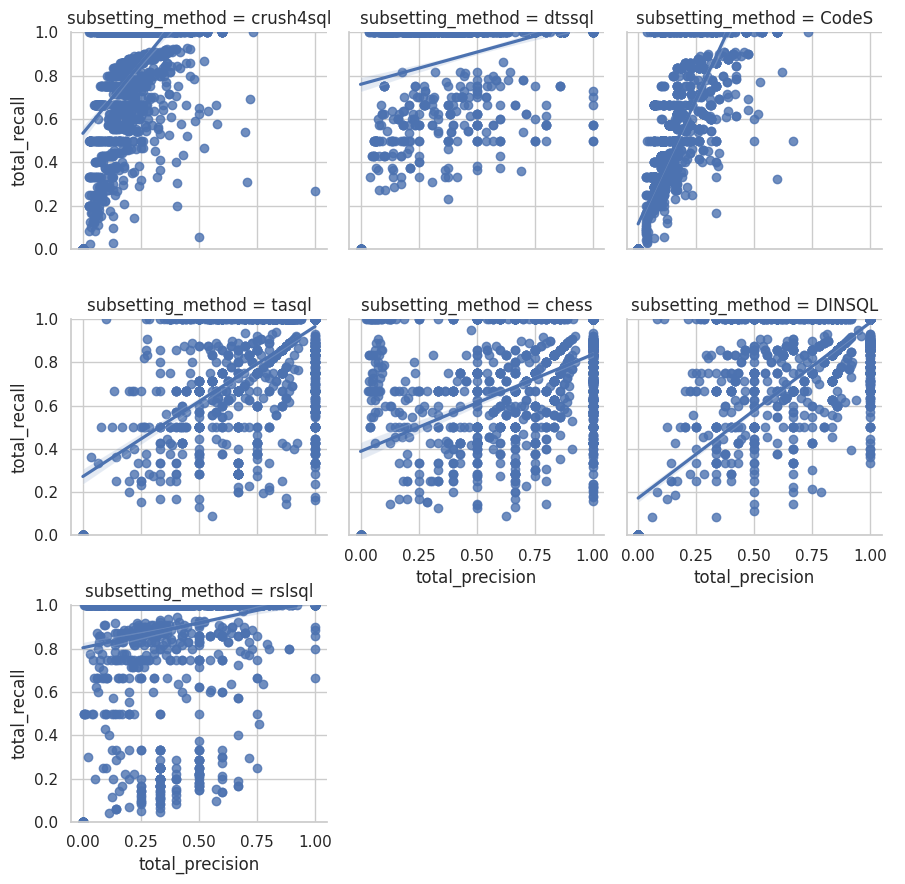

In [374]:
g = sns.FacetGrid(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    col="subsetting_method",
    col_wrap=3,
    # hue="benchmark"
)
# g.map(sns.scatterplot, "total_precision", "total_recall")
g.map(sns.regplot, "total_precision", "total_recall", scatter=True, truncate=True)
g.set(ylim=(0, 1))
g.add_legend()


### KDE of Precision x Recall for each subsetting method

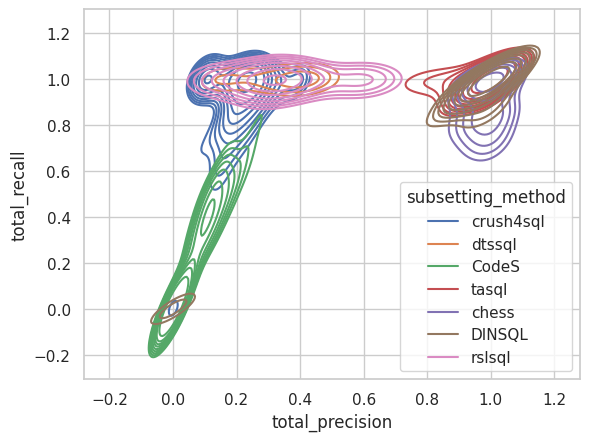

In [375]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and all_models_compatible and eval_model"),
    hue="subsetting_method",
    x="total_precision",
    y="total_recall",
    thresh=0.5,
    legend=True
)
sns.move_legend(g, loc="lower right")



### KDE of Precision x Recall for each subsetting method and benchmark

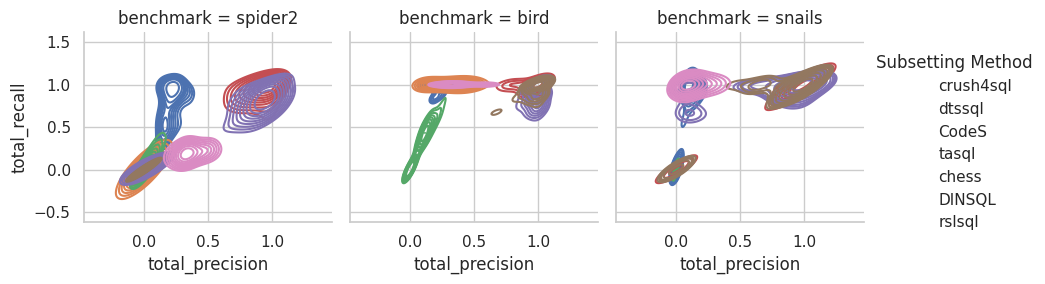

In [376]:
g = sns.FacetGrid(
    data=performance_df.query("prompt_tokens>=0 and all_models_compatible and eval_model"),
    hue="subsetting_method",
    col="benchmark"
)
g.map(sns.kdeplot, "total_precision", "total_recall", thresh=0.5, legend=True)
g.add_legend(title="Subsetting Method")


### KDE of Total Recall and Inference Time for each subsetting method

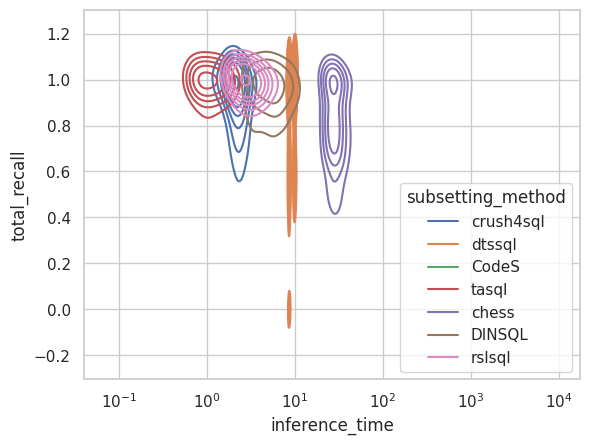

In [377]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    hue="subsetting_method",
    x="inference_time",
    y="total_recall",
    thresh=0.3,
    legend=True,
    log_scale=[10, False]
)
sns.move_legend(g, loc="lower right")


### KDE of Total Precision and Inference Time for each subsetting method

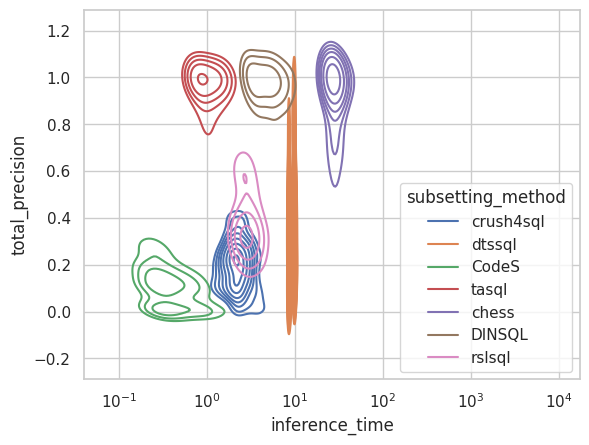

In [378]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    hue="subsetting_method",
    x="inference_time",
    y="total_precision",
    thresh=0.3,
    legend=True,
    log_scale=[10, False]
)
sns.move_legend(g, loc="lower right")


### KDE of Total f1 and Inference Time for each subsetting method

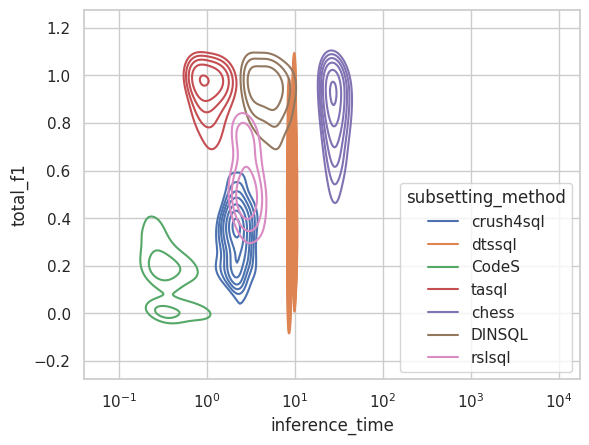

In [379]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    hue="subsetting_method",
    x="inference_time",
    y="total_f1",
    thresh=0.3,
    legend=True,
    log_scale=[10, False]
)
sns.move_legend(g, loc="lower right")


### Processing time (seconds per column) X Inference time (seconds per query)

<Figure size 640x480 with 0 Axes>

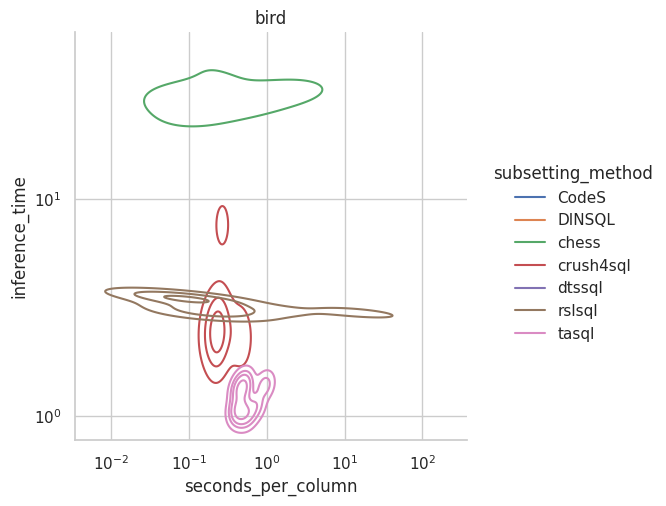

<Figure size 640x480 with 0 Axes>

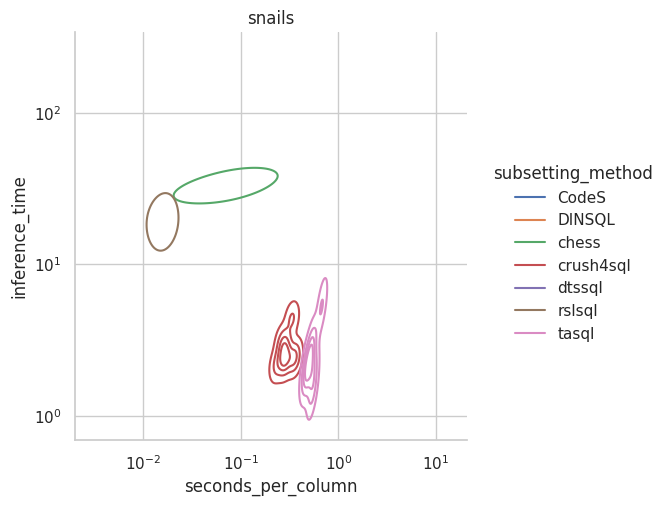

<Figure size 640x480 with 0 Axes>

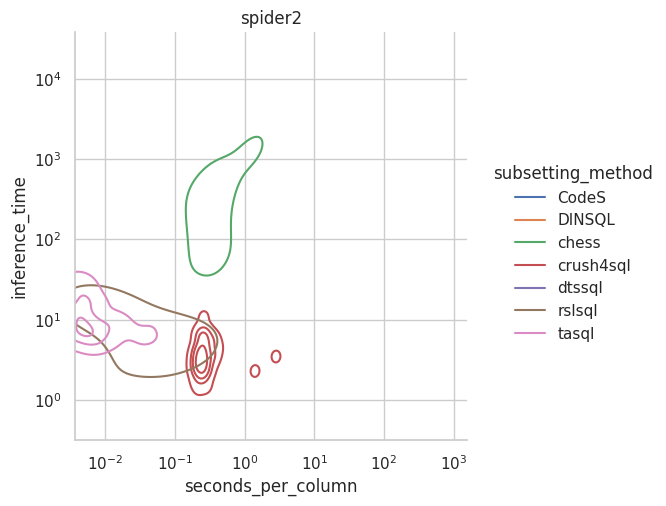

In [380]:
temp_data_df = performance_df.query("eval_model").set_index(["benchmark", "database", "subsetting_method"]).join(
    processing_time_df.set_index(["benchmark", "database", "subsetting_method"]), 
    lsuffix="perf_df_",
    rsuffix="proc_df"
).reset_index()[["benchmark", "database", "subsetting_method", "inference_time", "seconds_per_column"]].query(
    "inference_time>0"
)
temp_data_df = temp_data_df.groupby(by=["benchmark", "database", "subsetting_method"]).mean().reset_index()

for benchmark in temp_data_df.benchmark.unique():
    plt.figure()
    g = sns.displot(
        data=temp_data_df.query(f"benchmark=='{benchmark}'"),
        x="seconds_per_column",
        y="inference_time",
        hue="subsetting_method",
        kind="kde",
        log_scale=[True, True],
        thresh=0.1,
        levels=5
    )
    
    plt.title(benchmark)

# Performance Evaluation

## Schema Size Limitation Results

In [ ]:
temp_data_df = performance_df.query("eval_model").set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"]).sort_values(by="size_sort", ascending=False)
).reset_index().drop_duplicates(subset=["subsetting_method", "benchmark", "database"])
size_counts = {
    "S": 44, "M": 51, "L": 11, "XL": 19
}
temp_data_df = temp_data_df.query("prompt_tokens>=0").pivot_table(
    values=["database"],
    columns=["size_cat"],
    index=["subsetting_method"],
    aggfunc="count",
    fill_value="-"
)
temp_data_df.columns = [col[1].upper() for col in temp_data_df.columns]
temp_data_df = temp_data_df[["S", "M", "L", "XL"]].reset_index()
for s in size_counts.keys():
    temp_data_df[s] = temp_data_df[s].apply(lambda x: round(x / size_counts[s], 2) if x != "-" else x)
temp_data_df.to_latex(
    buf=f"{os.getcwd()}/tables/subsetting_schema_size_limits.tex",
    float_format="%.2f",
    index=False,
    header=["$\Psi$", "S", "M", "L", "XL"],
    label=f"tab:schema-size-limits",
    caption="Proportions of each schema size category that each subsetting method is capable of processing. Only 3 of the 7 evaluated methods are capable of processing all schemas."
)

/tmp/ipykernel_1891303/2412123461.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_data_df = temp_data_df.query("prompt_tokens>=0").pivot_table(


## Recall, Precision, and F1

### Recall, Precision, F1, and Schema Proportion Tables by Benchmark

In [382]:
for benchmark in performance_df.benchmark.unique():
    temp_data_df = performance_df.query(f"all_models_compatible==True and benchmark=='{benchmark}'").dropna(how="all")[[
        "Subsetting Method", "total_recall", "total_precision", "total_f1", 
        "table_recall", "table_precision", "table_f1",
        "column_recall", "column_precision", "column_f1",
        "subset_table_proportion", "subset_column_proportion"
        ]].groupby(["Subsetting Method"]).mean().reset_index()
    max_stats = {}
    for column in list(temp_data_df.columns):
        if column == "Subsetting Method":
            continue
        if "proportion" not in column:
            max_stats[column] = round(max(temp_data_df[column]), 2)
        else:
            max_stats[column] = round(min(temp_data_df.query(f"{column}>0")[column]), 2)
    for column in temp_data_df.columns:
        if column not in max_stats.keys():
            continue
        temp_data_df[column] = temp_data_df[column].apply(
            lambda x: str(round(x, 2)).replace(
                str(max_stats[column]), 
                ("\\textbf{" + str(max_stats[column]) + "}")
                )
        )
        temp_data_df[column] = temp_data_df[column].apply(lambda x: x + "0" if len(x) == 3 else x)
    latex_table = temp_data_df.to_latex(
        # buf=f"{os.getcwd()}/tables/{benchmark}_f1_rec_pre_prop_table.tex", 
        float_format="%.2f",
        index=False,
        header=["$\Psi$", "TotRec", "TotPre", "Totf1", "TabRec", "TabPre", "Tabf1", "ColRec", "ColPre", "Colf1", "TabPrp", "ColPrp"],
        label=f"tab:exp1-{benchmark}",
        caption=f"Experiment 1 Performance ({str.capitalize(benchmark)} Benchmark)"
        ).replace("{table}", "{table*}")
    with open(f"{os.getcwd()}/tables/{benchmark}_f1_rec_pre_prop_table.tex", "wt") as f:
        f.write(latex_table)

### Time, Recall, Precision, F1, and Schema Proportion Tables by Schema Size

In [383]:
for schema_size in schema_stat_df.size_cat.unique():
    temp_data_df = performance_df.set_index(["benchmark", "database"]).join(
            schema_stat_df.set_index(["benchmark", "database"])
        ).query(
            f"size_cat=='{schema_size}' and inference_time>0"
        ).dropna(how="all")[[
        "Subsetting Method", "inference_time", "prompt_tokens", "total_recall", "total_precision", "total_f1", 
        "table_recall", "table_precision", "table_f1",
        "column_recall", "column_precision", "column_f1",
        "subset_table_proportion", "subset_column_proportion"
        ]].groupby(["Subsetting Method"]).mean().reset_index()
    temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: int(x))
    temp_data_df = temp_data_df.query("total_f1 > 0")
    max_stats = {}
    for column in list(temp_data_df.columns):
        if column == "Subsetting Method":
            continue
        if "proportion" not in column and "time" not in column and "tokens" not in column:
            max_stats[column] = round(max(temp_data_df[column]), 2)
        elif "tokens" in column:
            max_stats[column] = min(temp_data_df.query(f"{column}>0")[column])
        else:
            max_stats[column] = round(min(temp_data_df.query(f"{column}>0.0")[column]), 2)
    for column in temp_data_df.columns:
        if column not in max_stats.keys():
            continue
        temp_data_df[column] = temp_data_df[column].apply(
            lambda x: str(round(x, 2)).replace(
                f"{str(max_stats[column])}", 
                ("\\textbf{" + str(max_stats[column]) + "}")
            ) if len(str(max_stats[column])) > 3  or (type(max_stats[column]) == int)   
            else str(round(x, 2))
        )
        temp_data_df[column] = temp_data_df[column].apply(lambda x: x + "0" if len(x) == 3 else x)
    temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: "-" if x == "0" else x)
    latex_table = temp_data_df.to_latex(
        # buf=f"{os.getcwd()}/tables/{benchmark}_f1_rec_pre_prop_table.tex", 
        float_format="%.2f",
        index=False,
        header=["$\Psi$", "Time (s)", "Tokens", "TotRec", "TotPre", "Totf1", "TabRec", "TabPre", "Tabf1", "ColRec", "ColPre", "Colf1", "TabPrp", "ColPrp"],
        label=f"tab:exp1-{schema_size}-schema",
        caption=f"Experiment 1 Performance ({str.upper(schema_size)} Schema Size)"
        ).replace("{table}", "{table*}")
    with open(f"{os.getcwd()}/tables/{schema_size}-schema_f1_rec_pre_prop_table.tex", "wt") as f:
        f.write(latex_table)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (All Databases)

This a first look, and one that isn't very useful. On the surface, it suggests pretty big differences between various subsetting methods. However, what we're not seeing here are the methods that weren't capable of handling very large schemas. So it's possible that those methods are being unfairly rewarded (or punished) compared to those that were able to take on the largest schemas. We'll need to separate out the databases that all methods were capable of handling, and compare only those across methods.

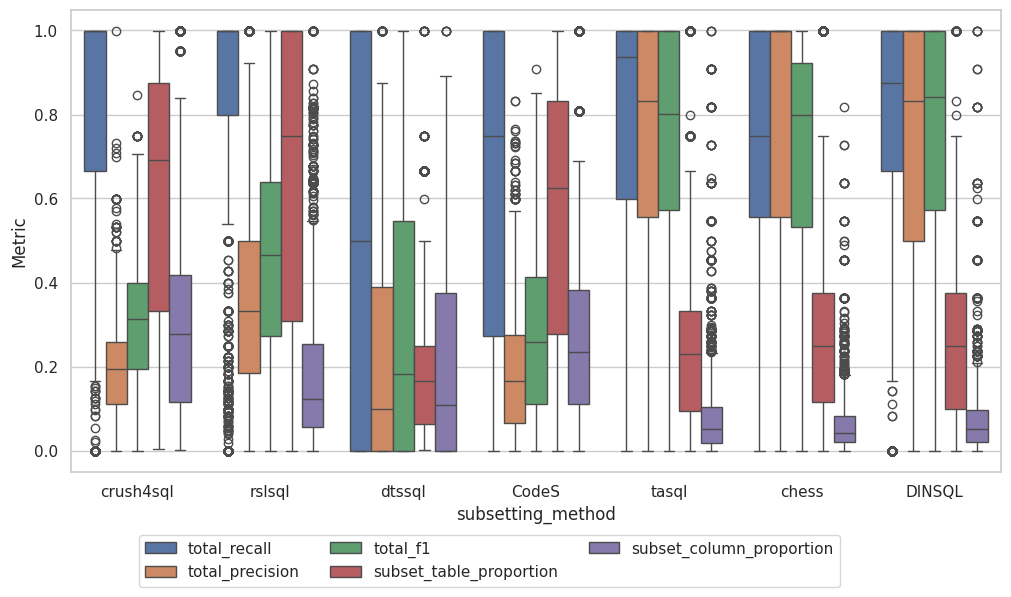

In [384]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (Only All-Model-Compatible Databases)

This is the same chart as above, except now we filter out the databases where some subsetting methods were unable to handle them due to schema size 

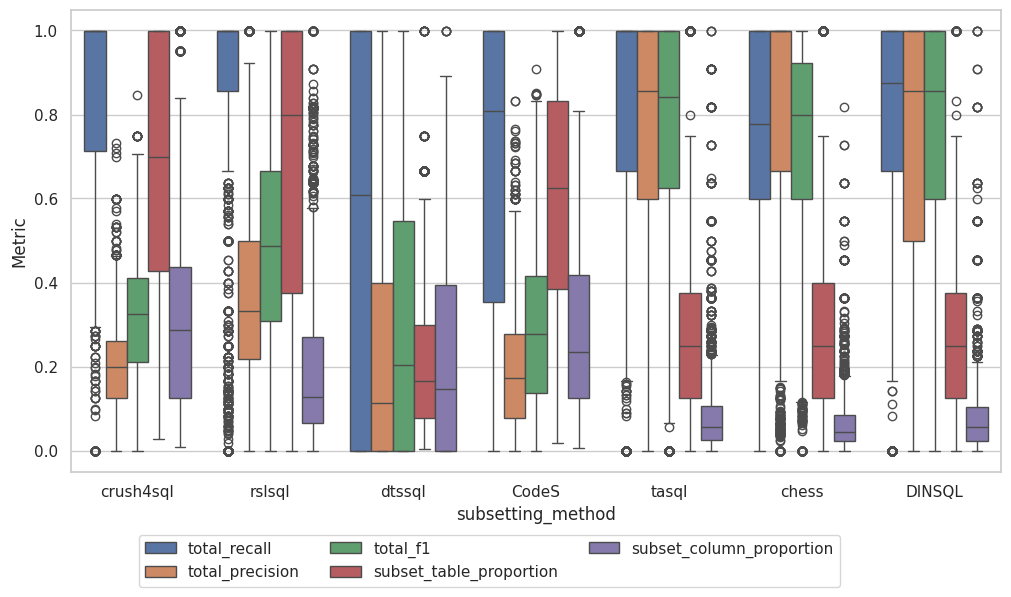

In [385]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and all_models_compatible"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (Only Very Large Database Schemas)

This is the same chart as above, except now we only compare the databases that were too large for at least one model

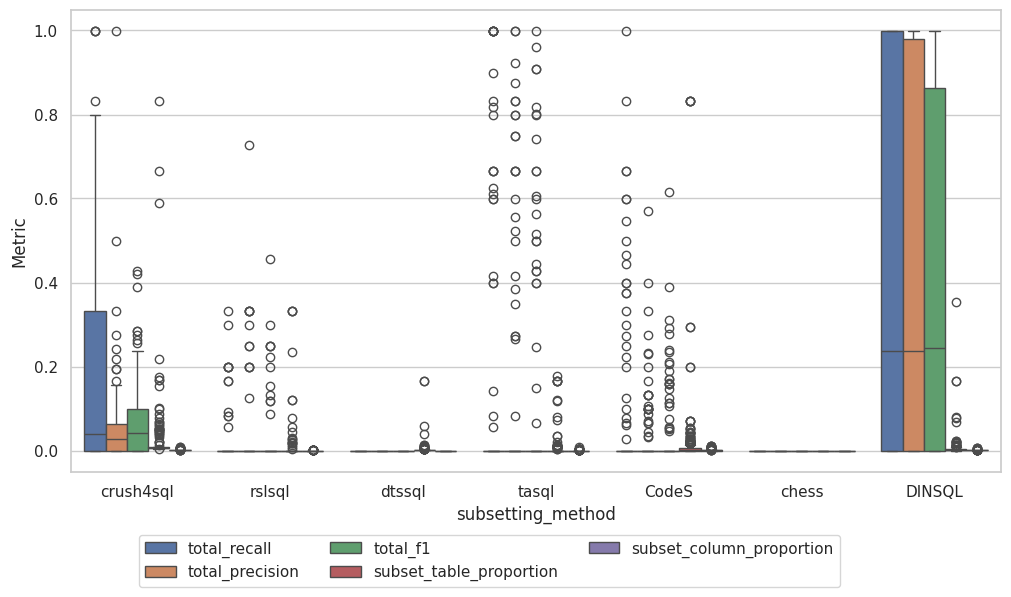

In [386]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and ~all_models_compatible"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Performance by Subsetting Method and Benchmark for All-Model-Compatible Schemas

<Figure size 1200x600 with 0 Axes>

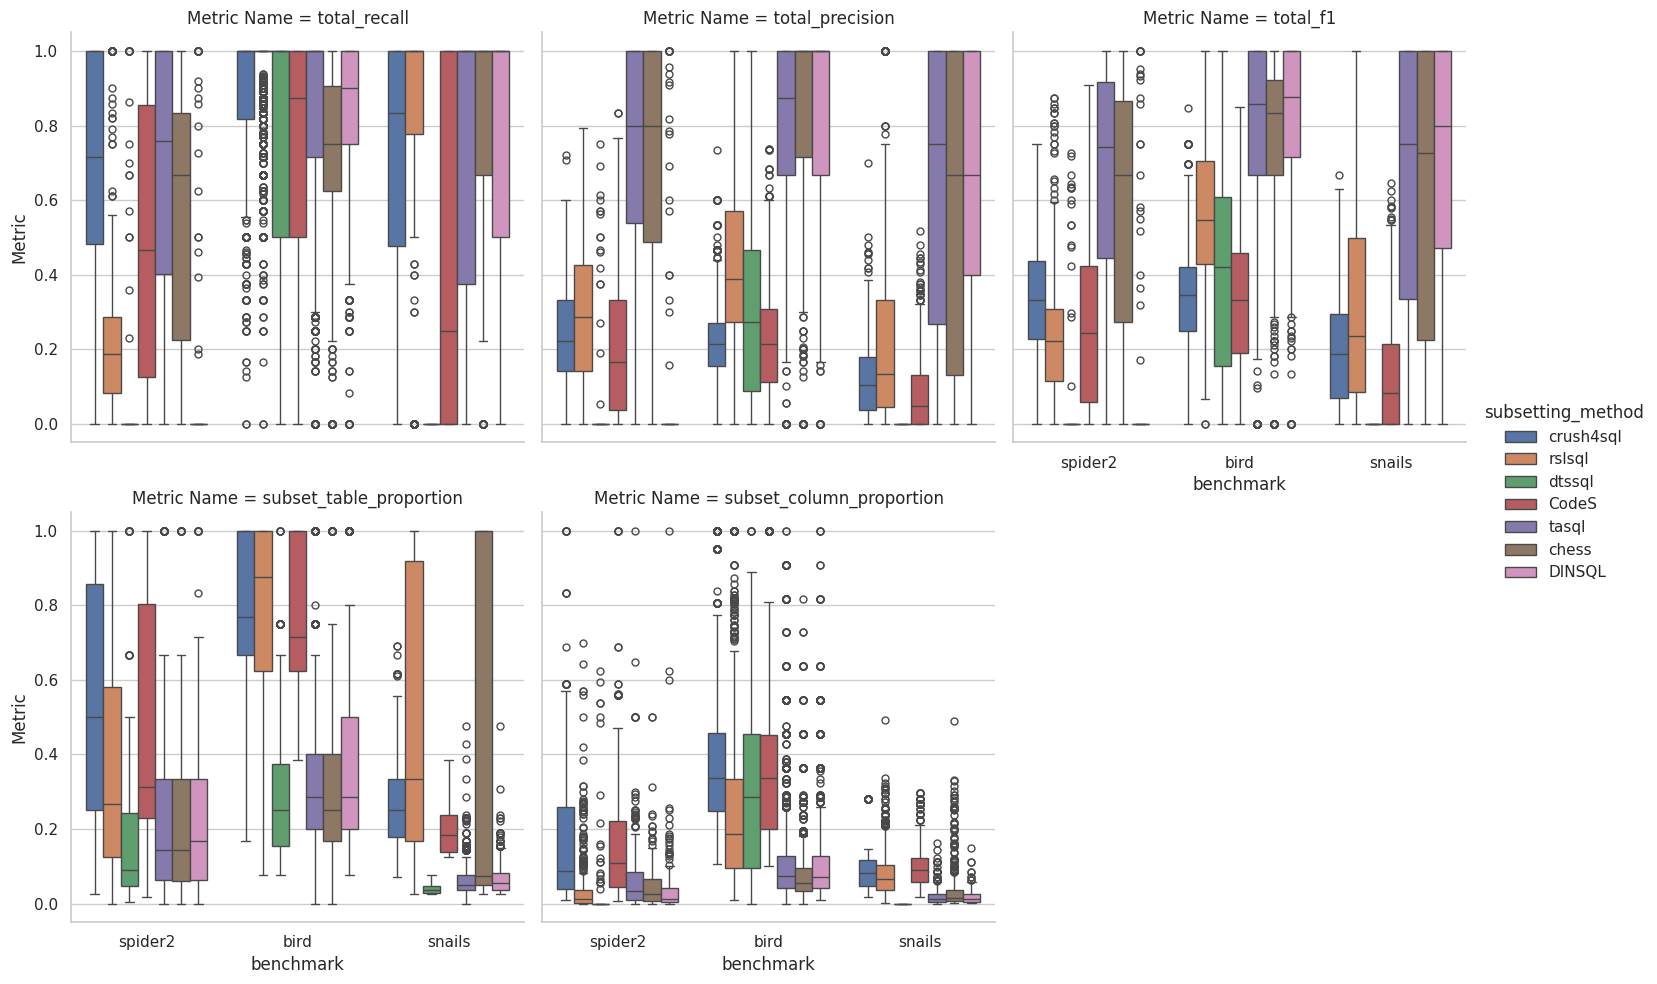

In [387]:
plt.figure(figsize=(12, 6))
sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and all_models_compatible"),
    x="benchmark",
    y="Metric",
    hue="subsetting_method",
    kind="box",
    col="Metric Name",
    col_wrap=3
)

## Inference Time

### Inference Time by Subsetting Method

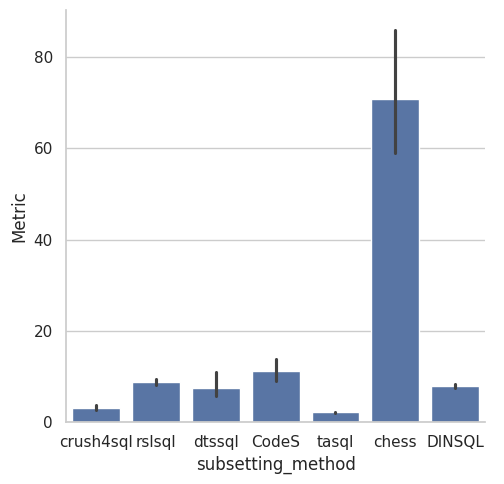

In [388]:
g = sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["inference_time"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric > 0"),
    kind="bar",
    x="subsetting_method",
    y="Metric"
)

## Token Usage

### Prompt Tokens by Subsetting Method

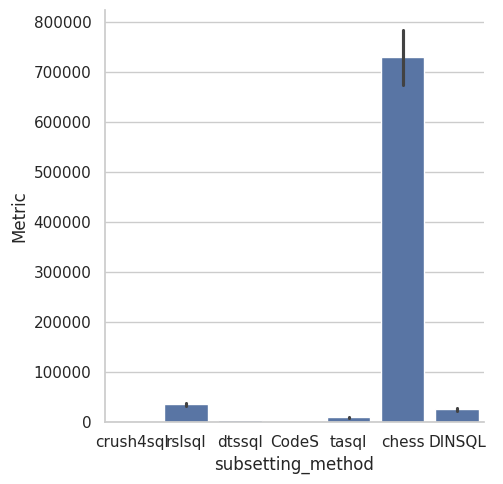

In [389]:
g = sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["prompt_tokens"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric >= 0"),
    kind="bar",
    x="subsetting_method",
    y="Metric"
)

# Pareto

## average total recall x average total precision for each method

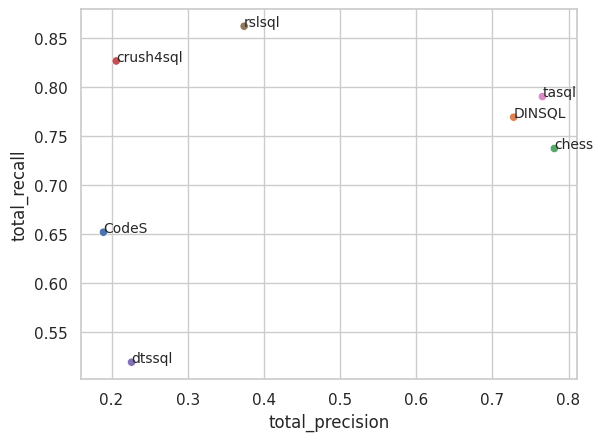

In [390]:
temp_data_df = performance_df.query(
    "all_models_compatible"
)[["subsetting_method", "total_recall", "total_precision"]].groupby(
    by=["subsetting_method"]
).mean()

sns.scatterplot(
    data=temp_data_df,
    x="total_precision",
    y="total_recall",
    hue="subsetting_method",
    legend=False
)
for line in temp_data_df.itertuples():
    plt.text(line.total_precision, line.total_recall, line.Index, fontsize="small")

## average table recall x average table precision for each method

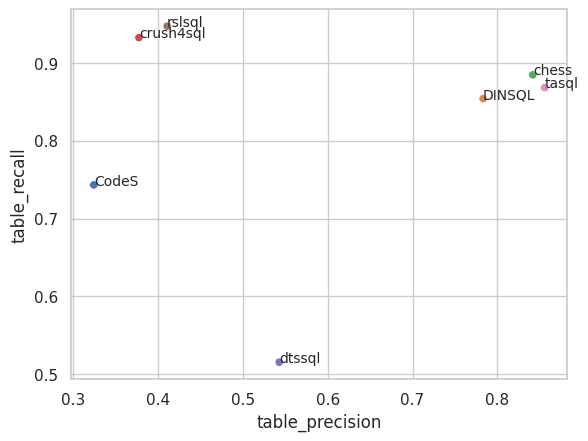

In [391]:
temp_data_df = performance_df.query(
    "all_models_compatible"
)[["subsetting_method", "table_recall", "table_precision"]].groupby(
    by=["subsetting_method"]
).mean()

sns.scatterplot(
    data=temp_data_df,
    x="table_precision",
    y="table_recall",
    hue="subsetting_method",
    legend=False
)
for line in temp_data_df.itertuples():
    plt.text(line.table_precision, line.table_recall, line.Index, fontsize="small")

## average column recall x average column precision for each method

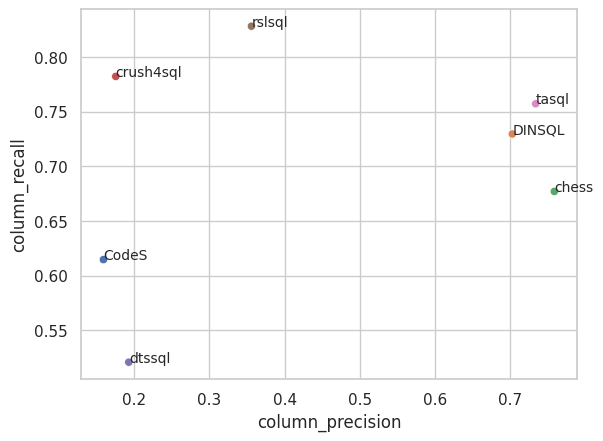

In [392]:
temp_data_df = performance_df.query(
    "all_models_compatible"
)[["subsetting_method", "column_recall", "column_precision"]].groupby(
    by=["subsetting_method"]
).mean()

sns.scatterplot(
    data=temp_data_df,
    x="column_precision",
    y="column_recall",
    hue="subsetting_method",
    legend=False
)
for line in temp_data_df.itertuples():
    plt.text(line.column_precision, line.column_recall, line.Index, fontsize="small")

## average total recall x average total precision for each method and benchmark

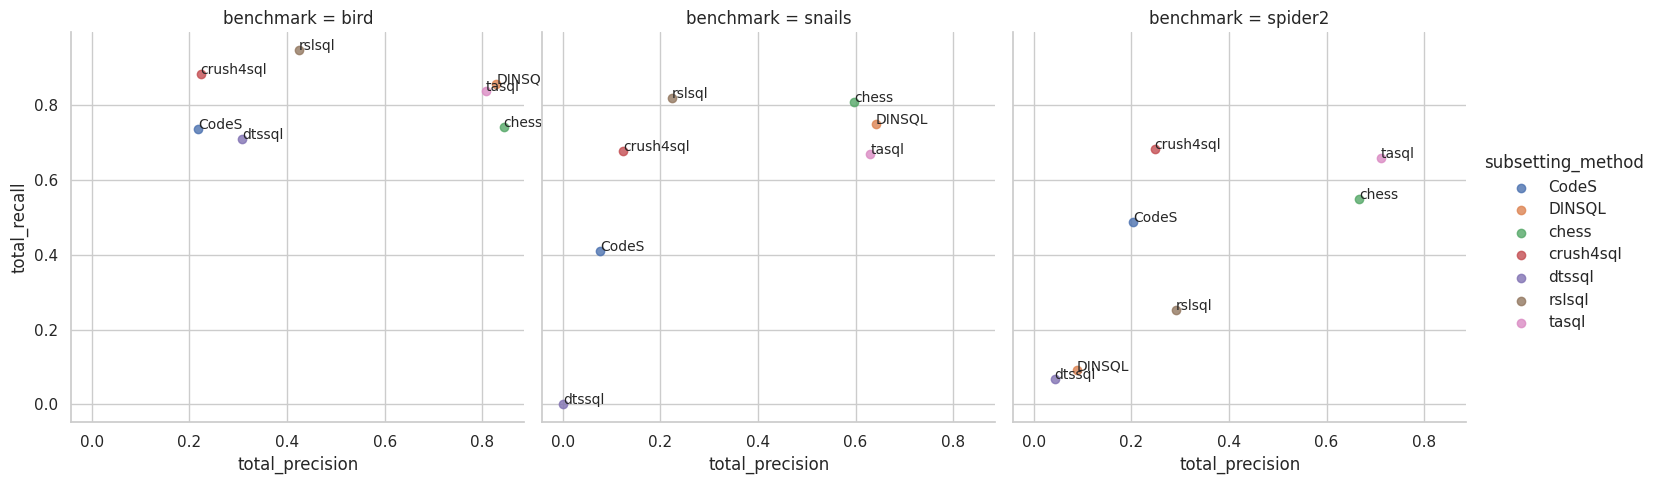

In [393]:
temp_data_df = performance_df.query(
    "all_models_compatible==True"
)[["subsetting_method", "benchmark", "total_recall", "total_precision"]].groupby(
    by=["subsetting_method", "benchmark"]
).mean().reset_index()

g = sns.lmplot(
    data=temp_data_df,
    x="total_precision",
    y="total_recall",
    hue="subsetting_method",
    col="benchmark",
    legend=True
)

for line in temp_data_df.itertuples():
    g.axes[0, {"bird":0, "snails":1, "spider2":2}[line.benchmark]].text(
        line.total_precision, line.total_recall, line.subsetting_method, fontsize="small"
        )


## average table recall x average table precision for each method and benchmark

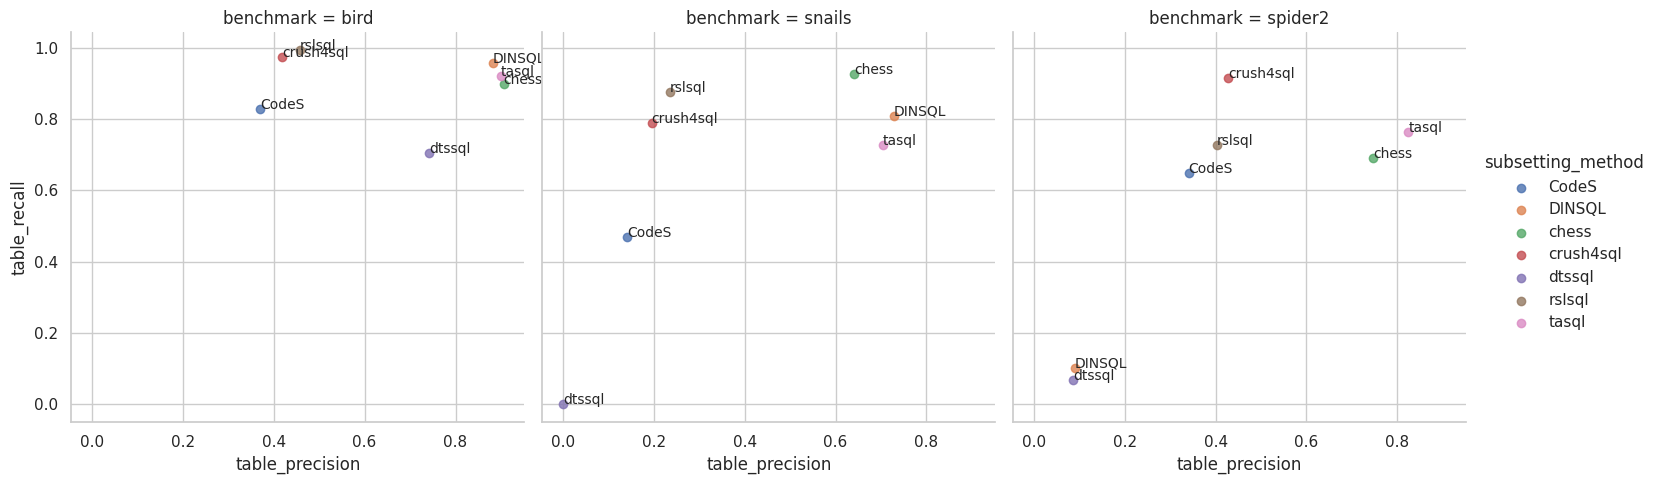

In [394]:
temp_data_df = performance_df.query(
    "all_models_compatible==True"
)[["subsetting_method", "benchmark", "table_recall", "table_precision"]].groupby(
    by=["subsetting_method", "benchmark"]
).mean().reset_index()

g = sns.lmplot(
    data=temp_data_df,
    x="table_precision",
    y="table_recall",
    hue="subsetting_method",
    col="benchmark",
    legend=True
)

for line in temp_data_df.itertuples():
    g.axes[0, {"bird":0, "snails":1, "spider2":2}[line.benchmark]].text(
        line.table_precision, line.table_recall, line.subsetting_method, fontsize="small"
        )


## average column recall x average column precision for each method and benchmark

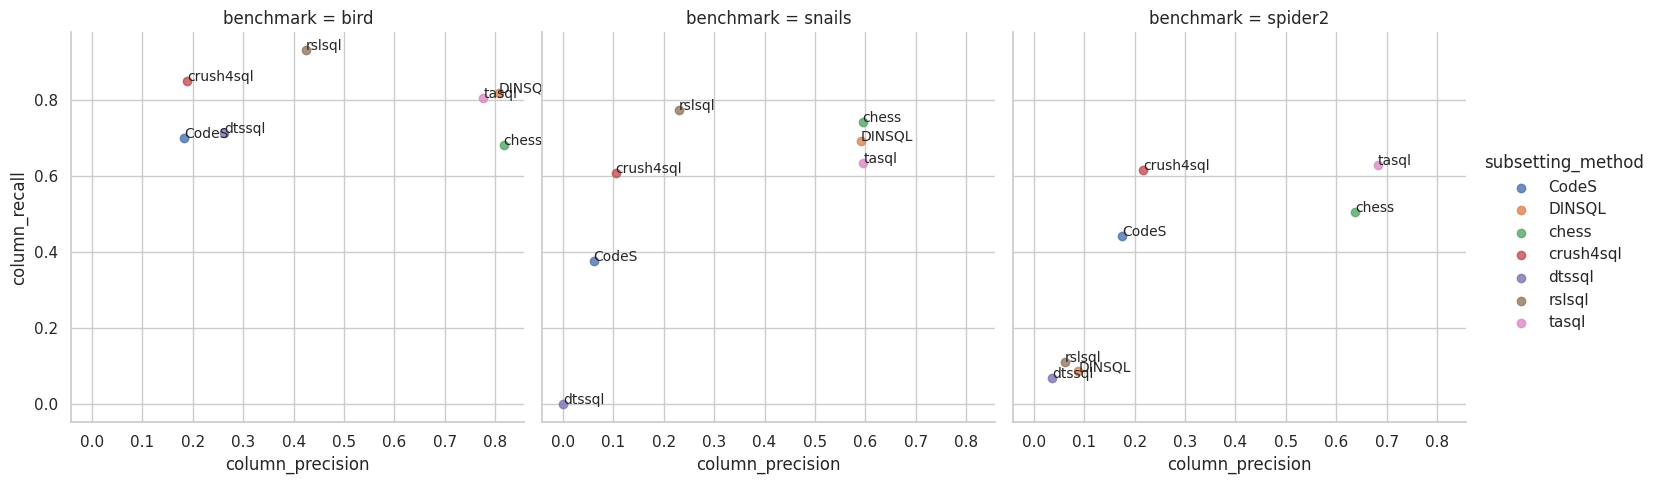

In [395]:
temp_data_df = performance_df.query(
    "all_models_compatible==True"
)[["subsetting_method", "benchmark", "column_recall", "column_precision"]].groupby(
    by=["subsetting_method", "benchmark"]
).mean().reset_index()

g = sns.lmplot(
    data=temp_data_df,
    x="column_precision",
    y="column_recall",
    hue="subsetting_method",
    col="benchmark",
    legend=True
)

for line in temp_data_df.itertuples():
    g.axes[0, {"bird":0, "snails":1, "spider2":2}[line.benchmark]].text(
        line.column_precision, line.column_recall, line.subsetting_method, fontsize="small"
        )
